In [1]:
# Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, ks_2samp

In [102]:
import pandas as pd
from sklearn.impute import KNNImputer

def knn_impute1(df, target_features):
    """
    Impute missing values using KNNImputer, skipping the target features.

    Parameters:
    - df: DataFrame containing the features and target column with missing values.
    - target_features: List of target feature names to be excluded from imputation.

    Returns:
    - DataFrame with missing values imputed (excluding the target features).
    - Imputation success percentage.
    """
    # Print before imputation
    print("Before Imputation")
    print("Shape:", df.shape)
    print("Missing values by column before imputation:")
    print(df.isnull().sum())
    
    # Separate the target features from the rest of the data
    df_features = df.drop(columns=target_features)
    df_targets = df[target_features]
    
    # Separate numerical and categorical features
    numerical_features = df_features.select_dtypes(include=['number']).columns
    categorical_features = df_features.select_dtypes(include=['category']).columns

    # Process categorical features
    df_categorical = df_features[categorical_features].copy()
    
    # Process numerical features
    df_numerical = df_features[numerical_features].copy()

    # Store original data types
    original_dtypes = df_numerical.dtypes

    # Count missing values before imputation
    missing_before = df_numerical.isnull().sum().sum()

    # Define and apply KNNImputer
    knn_imputer = KNNImputer(n_neighbors=5)
    df_numerical_imputed = knn_imputer.fit_transform(df_numerical)
    
    # Create DataFrame with imputed numerical data
    df_numerical_imputed = pd.DataFrame(df_numerical_imputed, columns=numerical_features)
    
    # Restore original data types
    for col in df_numerical_imputed.columns:
        if original_dtypes[col] == 'int64':
            df_numerical_imputed[col] = df_numerical_imputed[col].round().astype('int64')
        else:
            df_numerical_imputed[col] = df_numerical_imputed[col].astype(original_dtypes[col])

    # Combine imputed numerical features with categorical features
    df_imputed = pd.concat([df_numerical_imputed, df_categorical.reset_index(drop=True)], axis=1)
    
    # Combine imputed features with the original target features
    df_final = pd.concat([df_imputed, df_targets.reset_index(drop=True)], axis=1)
    
    # Count missing values after imputation
    missing_after = df_numerical_imputed.isnull().sum().sum()

    # Calculate the imputation success percentage
    success_percentage = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 100

    # Print after imputation
    print("\nAfter Imputation")
    print("Shape:", df_final.shape)
    print("Missing values by column after imputation:")
    print(df_final.isnull().sum())
    print(f"Imputation Success Percentage: {success_percentage:.2f}%")

    return df_final, success_percentage

# Example usage:
# df_final, success = knn_impute1(df, ['target_column1', 'target_column2'])


In [118]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def random_forest_impute(df, target_column):
    """
    Impute missing values using Random Forest regression.

    Parameters:
    - df: DataFrame containing the features and target column with missing values.
    - target_column: The name of the column to be imputed.

    Returns:
    - DataFrame with missing values imputed.
    - Imputation success percentage based on improvement.
    """
    # Print before imputation
    print("Before Imputation")
    print("Shape:", df.shape)
    print("Missing values by column before imputation:")
    print(df.isnull().sum())

    # Separate the target column from the rest of the data
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Create a preprocessing pipeline for categorical and numerical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

    # Create a pipeline with preprocessing and the Random Forest regressor
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    # Separate rows with and without missing target values
    X_train = X[y.notnull()]
    y_train = y[y.notnull()]
    X_missing = X[y.isnull()]

    # If there are no missing values, return the original DataFrame
    if X_missing.empty:
        print("No missing values to impute.")
        return df, 100.0

    # Train the Random Forest regressor
    rf_pipeline.fit(X_train, y_train)

    # Predict missing values
    y_pred = rf_pipeline.predict(X_missing)

    # Impute the missing values in the original DataFrame
    df.loc[df[target_column].isnull(), target_column] = y_pred

    # Count missing values after imputation
    missing_after = df[target_column].isnull().sum()

    # Calculate the imputation success percentage
    missing_before = y.isnull().sum()
    success_percentage = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 100

    # Print after imputation
    print("\nAfter Imputation")
    print("Shape:", df.shape)
    print("Missing values by column after imputation:")
    print(df.isnull().sum())
    print(f"Imputation Success Percentage: {success_percentage:.2f}%")

    return df, success_percentage

# Example usage:
# df_final2, success = random_forest_impute(df_final1, 'popularity')



In [135]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def encode_and_catimpute(df: pd.DataFrame, column_name: str) -> (pd.DataFrame, float):
    """
    Converts categorical data in a specified column to numeric labels,
    imputes missing values, and calculates the success rate of imputation.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing the data.
    - column_name: str - The name of the column to encode and impute.

    Returns:
    - pd.DataFrame - The DataFrame with the encoded and imputed column.
    - float - The success rate of imputation (ratio of imputed values to total missing values).
    """
    # Copy the DataFrame to avoid modifying the original data
    df_copy = df.copy()
    
    # Count missing values before imputation
    missing_before = df_copy[column_name].isnull().sum()
    
    # Print missing values before imputation
    print(f"Missing values before imputation in '{column_name}': {missing_before}")
    
    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    
    # Convert categorical data to numeric labels
    df_copy[column_name + '_encoded'] = label_encoder.fit_transform(df_copy[column_name].astype(str))
    
    # Initialize SimpleImputer with the most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    
    # Impute missing values in the encoded column
    df_copy[column_name + '_encoded'] = imputer.fit_transform(df_copy[[column_name + '_encoded']])
    
    # Convert numeric labels back to original categories (optional)
    df_copy[column_name + '_imputed'] = label_encoder.inverse_transform(df_copy[column_name + '_encoded'].astype(int))
    
    # Count missing values in the imputed column
    missing_after = df_copy[column_name + '_imputed'].isnull().sum()
    
    # Print missing values after imputation
    print(f"Missing values after imputation in '{column_name}_imputed': {missing_after}")
    
    # Calculate the success rate of imputation
    success_rate = (missing_before - missing_after) / missing_before if missing_before > 0 else 1.0
    
    return df_copy, success_rate




In [107]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # Required to use IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

def mice_impute_with_categorical(df, target_features):
    """
    Impute missing values using IterativeImputer (MICE), including categorical variables.

    Parameters:
    - df: DataFrame containing the features and target column with missing values.
    - target_features: List of target feature names to be excluded from imputation.

    Returns:
    - DataFrame with missing values imputed (excluding the target features).
    - Imputation success percentage based on improvement.
    """
    # Print before imputation
    print("Before Imputation")
    print("Shape:", df.shape)
    print("Missing values by column before imputation:")
    print(df.isnull().sum())

    # Separate the target features from the rest of the data
    df_features = df.drop(columns=target_features)
    df_targets = df[target_features]

    # Separate numerical and categorical features
    numerical_features = df_features.select_dtypes(include=['number']).columns
    categorical_features = df_features.select_dtypes(exclude=['number']).columns

    # Process categorical features
    df_categorical = df_features[categorical_features].copy()

    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in df_categorical.columns:
        le = LabelEncoder()
        df_categorical[col] = df_categorical[col].astype(str)  # Ensure all data is string
        df_categorical[col] = le.fit_transform(df_categorical[col].fillna('missing'))
        label_encoders[col] = le

    # Process numerical features
    df_numerical = df_features[numerical_features].copy()

    # Combine numerical and categorical features for IterativeImputer
    df_combined = pd.concat([df_numerical, df_categorical], axis=1)

    # Store original data types
    original_dtypes = df_numerical.dtypes

    # Count missing values before imputation
    missing_before = df_combined.isnull().sum().sum()

    # Define and apply IterativeImputer (MICE)
    mice_imputer = IterativeImputer(max_iter=10, random_state=0)
    df_imputed = mice_imputer.fit_transform(df_combined)

    # Convert back to DataFrame
    df_imputed = pd.DataFrame(df_imputed, columns=df_combined.columns)

    # Restore original data types
    for col in df_numerical.columns:
        if original_dtypes[col] == 'int64':
            df_imputed[col] = df_imputed[col].round().astype('int64')
        else:
            df_imputed[col] = df_imputed[col].astype(original_dtypes[col])

    # Decode categorical features back to original labels
    for col in df_categorical.columns:
        le = label_encoders[col]
        df_imputed[col] = df_imputed[col].round().astype(int)
        df_imputed[col] = le.inverse_transform(df_imputed[col])

    # Combine imputed features with the original target features
    df_final = pd.concat([df_imputed, df_targets.reset_index(drop=True)], axis=1)

    # Count missing values after imputation
    missing_after = df_imputed.isnull().sum().sum()

    # Calculate the imputation success percentage based on improvement
    success_percentage = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 0

    # Print after imputation
    print("\nAfter Imputation")
    print("Shape:", df_final.shape)
    print("Missing values by column after imputation:")
    print(df_final.isnull().sum())
    print(f"Imputation Success Percentage: {success_percentage:.2f}%")

    return df_final, success_percentage

# Example usage:
# df_final, success = mice_impute_with_categorical(df, ['target_column1', 'target_column2'])


In [3]:
import pandas as pd
from sklearn.impute import KNNImputer

def knn_impute_preserve_structure(df, target_feature):
    """
    Impute missing values using KNNImputer, ensuring the original data types, column order, and structure are preserved.
    
    Parameters:
    - df: DataFrame containing the features and target column with missing values.
    - target_feature: The name of the target feature to be excluded from imputation.

    Returns:
    - DataFrame with missing values imputed, with original data types, structure, and order preserved.
    """
    # Copy original dtypes and columns
    original_dtypes = df.dtypes
    original_columns = df.columns

    # Separate target feature
    df_features = df.drop(columns=[target_feature])
    df_target = df[[target_feature]]

    # Impute only the numerical columns
    numerical_features = df_features.select_dtypes(include=['number']).copy()

    # Apply KNNImputer to numerical columns
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_numerical = knn_imputer.fit_transform(numerical_features)
    
    # Convert the imputed data back to a DataFrame and ensure the original dtypes
    df_imputed_numerical = pd.DataFrame(imputed_numerical, columns=numerical_features.columns, index=numerical_features.index)
    df_imputed_numerical = df_imputed_numerical.astype(numerical_features.dtypes)

    # Restore integer columns to their original dtype
    for col in df_imputed_numerical.columns:
        if original_dtypes[col] == 'int64':
            df_imputed_numerical[col] = df_imputed_numerical[col].round().astype('int64')

    # Handle categorical columns separately to preserve them
    categorical_features = df_features.select_dtypes(include=['category']).copy()
    categorical_features = categorical_features.apply(lambda x: x.cat.add_categories('missing').fillna('missing'))

    # Recombine the imputed numerical columns with categorical columns and the target feature
    df_final = pd.concat([df_imputed_numerical, categorical_features, df_target], axis=1)
    
    # Ensure the column order and labels match the original
    df_final = df_final[original_columns]

    # Check if everything matches
    print("Before Imputation")
    print(f"Shape: {df.shape}")
    print(f"Column Types:\n{df.dtypes}")

    print("\nAfter Imputation")
    print(f"Shape: {df_final.shape}")
    print(f"Column Types:\n{df_final.dtypes}")

    # Check if the column order and labels match
    if not df.columns.equals(df_final.columns):
        raise ValueError("The column order or labels do not match between the original and final DataFrames.")

    # Calculate the differences
    differences = (df != df_final).sum().sum()
    print(f"Number of values changed during imputation: {differences}")

    return df_final

# Example usage:
# df_imputed = knn_impute_preserve_structure(df, target_feature='popularity')


In [4]:
import pandas as pd

def calculate_absolute_episode_run_time(df):
    """
    Calculate the absolute episode run time for TV series based on the number of episodes and seasons.

    Args:
    df (pd.DataFrame): The DataFrame containing the data with columns 'number_of_seasons', 'number_of_episodes', and 'episode_run_time'.

    Returns:
    pd.DataFrame: The DataFrame with an additional column 'absolute_episode_run_time' in minutes.
    """

    # Function to calculate absolute run time
    def calculate_runtime(row):
        # Calculate total runtime using the number of episodes and episode run time
        absolute_runtime = row['number_of_episodes'] * row['episode_run_time']
        return absolute_runtime

    # Apply the function to calculate the absolute run time
    df['absolute_episode_run_time'] = df.apply(calculate_runtime, axis=1)

    return df

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import pandas as pd

def scale_and_encode(df_imputed, scale_columns, scaler_type='minmax'):
    # Define numerical and categorical features
    numerical_features = scale_columns
    categorical_features = [col for col in df_imputed.columns if df_imputed[col].dtype == 'object']
    
    # Extract unchanged columns
    unchanged_columns = [col for col in df_imputed.columns if col not in numerical_features + categorical_features]
    unchanged_data = df_imputed[unchanged_columns]
    
    # Print the shape before transformation
    print("Shape before transformation:", df_imputed.shape)
    
    # Apply scaling to numerical features
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Unsupported scaler_type")
    
    # Fit and transform numerical data
    scaled_numerical_data = scaler.fit_transform(df_imputed[numerical_features])
    
    # Create DataFrame for scaled numerical data
    scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_features)
    
    # Apply one-hot encoding to categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output instead of sparse
    encoded_categorical_data = encoder.fit_transform(df_imputed[categorical_features])
    
    # Create DataFrame for encoded categorical data
    encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))
    
    # Concatenate scaled numerical data, encoded categorical data, and unchanged columns
    df_transformed = pd.concat([scaled_numerical_df, encoded_categorical_df, unchanged_data.reset_index(drop=True)], axis=1)
    
    # Print the shape after transformation
    print("Shape after transformation:", df_transformed.shape)
    
    return df_transformed


In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

def outliers_boxplot(df):
    # Filter out only numeric columns, including both float64 and int64
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['category']).columns  # or ['category'] if using categorical dtype
    
    epsilon = 1e-10  # Small constant to avoid issues with zero values

    # Handle numeric columns
    valid_numeric_cols = [col for col in numeric_cols if df[col].dropna().size > 0]
    
    if valid_numeric_cols:
        num_numeric_plots = len(valid_numeric_cols)
        ncols = 2
        nrows = (num_numeric_plots + ncols - 1) // ncols  # Calculate rows needed

        plt.figure(figsize=(15, nrows * 5 + 5))  # Adjust height based on number of rows
        
        for i, col in enumerate(valid_numeric_cols):
            ax = plt.subplot(nrows, ncols, i + 1)
            data = df[col].dropna()

            # Clean data by removing infinite values and adding epsilon to avoid zero issues
            data = data[np.isfinite(data)]
            if data.size > 0:
                if data.std() == 0:  # Handle zero variance
                    data += epsilon  # Add epsilon to avoid plotting issues
                    ax.hist(data, bins=1, edgecolor='black')
                    ax.set_title(f'NUM - Uniform Data: {col}', fontsize=12)
                    ax.set_xlabel(f'{col}', fontsize=10)
                    ax.set_ylabel('Count')
                else:
                    try:
                        sb.boxplot(data=data, ax=ax)
                        ax.set_title(f'NUM - Box Plot: {col}', fontsize=12)
                        ax.set_xlabel(f'{col}', fontsize=10)
                    except ValueError as e:
                        print(f"Error plotting {col} as box plot: {e}")
                        data += epsilon  # Add epsilon to avoid plotting issues
                        ax.hist(data, bins=1, edgecolor='black')  # Handle as histogram on error
                        ax.set_title(f'NUM - Error Plotting: {col}', fontsize=12)
                        ax.set_xlabel(f'{col}', fontsize=10)
                        ax.set_ylabel('Count')
            else:
                ax.set_visible(False)  # Hide subplot if there's no data
        
        plt.subplots_adjust(hspace=0.7, top=0.9)  # Adjust space between subplots
        # plt.show() re
    
    # Handle categorical columns
    if categorical_cols.size > 0:
        # Adjust the figsize for a smaller plot
        plt.figure(figsize=(8, len(categorical_cols) * 4))  # Adjust width and height as needed
    
        for i, col in enumerate(categorical_cols):
            ax = plt.subplot(len(categorical_cols), 1, i + 1)
            sb.countplot(data=df, x=col, ax=ax)
            ax.set_title(f'CAT - Count Plot: {col}', fontsize=10)  # Adjust font size for titles
            ax.set_xlabel(f'{col}', fontsize=8)  # Adjust font size for x labels
            ax.set_ylabel('Count', fontsize=8)  # Adjust font size for y labels
    
        plt.tight_layout()  # Adjusts layout to prevent overlap
        plt.show()

In [7]:
def drop_zero_or_epsilon(df, column, epsilon):
    # Print the number of rows before dropping
    rows_before = df.shape[0]
    print(f"Number of rows before dropping: {rows_before}")

    # Drop rows where the specified column has values of 0 or epsilon
    df_cleaned = df[~df[column].isin([0, epsilon])]

    # Print the number of rows after dropping
    rows_after = df_cleaned.shape[0]
    print(f"Number of rows after dropping: {rows_after}")

    return df_cleaned



In [8]:
import pandas as pd
import numpy as np

def calculate_statistics(df, column, epsilon):
    # Calculate statistics
    count_nan = df[column].isna().sum()
    count_zero = (df[column] == 0).sum()
    count_epsilon = (df[column] == epsilon).sum()
    
    # Print results
    print(f"Statistics for column '{column}':")
    print(f"Count of NaN values: {count_nan}")
    print(f"Count of 0 values: {count_zero}")
    print(f"Count of values equal to epsilon ({epsilon}): {count_epsilon}")


In [9]:
                         # show me  zeros negative Nans    


def check_and_adjust_column(df, column_name, epsilon= 1e-10 ):
    """ Check and adjust column for zeros, negatives, and NaNs. """
    column = df[column_name]
    
    # Check for zeros, negatives, and NaNs
    count_zeros = (column == 0).sum()
    count_negatives = (column < 0).sum()
    count_nans = column.isna().sum()
   
    # Adjust values
    if count_zeros > 0:
        df[column_name] = column.replace(0, epsilon)
    if count_negatives > 0:
        df[column_name] = df[column_name].clip(lower=epsilon)
    
    # Return counts
    return count_zeros, count_negatives, count_nans

def recheck_and_print(df, epsilon= 1e-10):
    """ Recheck columns after adjustment and print the results. """
    results = {}
    
    for col in df.columns:
        count_zeros, count_negatives, count_nans = check_and_adjust_column(df, col, epsilon)
        results[col] = {
            'zeros': count_zeros,
            'negatives': count_negatives,
            'nans': count_nans
        }
    
    # Print the results
    for column, counts in results.items():
        print(f"Column: {column}")
        print(f"  Zeros treated: {counts['zeros']}")
        print(f"  Negatives treated: {counts['negatives']}")
        print(f"  NaNs: {counts['nans']}")
        print()


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

def analyze_outliers_OLD(continuous_df, outliers_df, column):
    """
    Analyzes the impact of outliers on correlation and distribution for a given column.

    Parameters:
    - continuous_df: pandas DataFrame containing the continuous data.
    - outliers_df: pandas DataFrame containing outlier flags.
    - column: string, the column name to analyze.

    Returns:
    - A DataFrame with analysis results for the given column.
    """
    out = continuous_df[column]
    non_out = continuous_df[column][outliers_df[column] == 0]  # Non-outliers
    
    cor_out = continuous_df['popularity']
    cor_non_out = continuous_df['popularity'][outliers_df[column] == 0]
    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    return pd.DataFrame({'feature': [column],
                         'outliers_cnt': [outliers_df[column].sum()],
                         'distribution_changed': [dist_change],
                         'correlation_changed': [cor_change]})

def process_outlier_columns_OLD(continuous_df, outliers_df):
    """
    Processes columns to analyze the impact of outliers on correlation and distribution.

    Parameters:
    - continuous_df: pandas DataFrame containing continuous data.
    - outliers_df: pandas DataFrame containing outlier flags.

    Returns:
    - A DataFrame with the analysis results for all common columns.
    """
    # Initialize the result DataFrame
    out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

    # Filter the columns to ensure only those present in both DataFrames are processed
    common_columns = continuous_df.columns.intersection(outliers_df.columns)

    for col in common_columns:
        new_row = analyze_outliers_OLD(continuous_df, outliers_df, col)
        out_df = pd.concat([out_df, new_row], ignore_index=True)

    return out_df



In [11]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

def analyze_outliers1(continuous_df, outliers_df, column, targetcolumn='popularity' ):
    """
    Analyzes the impact of outliers on correlation and distribution for a given column.

    Parameters:
    - continuous_df: pandas DataFrame containing the continuous data.
    - outliers_df: pandas DataFrame containing outlier flags.
    - column: string, the column name to analyze.

    Returns:
    - A DataFrame with analysis results for the given column.
    """
    out = continuous_df[column]
    non_out = continuous_df[column][outliers_df[column] == 0]  # Non-outliers

    # want to verify that target is not harmed 
    cor_out = continuous_df[targetcolumn]
    cor_non_out = continuous_df[targetcolumn][outliers_df[column] == 0]
    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'
    
    # Determine if the feature should be dropped
    drop = 'yes' if dist_change == '+' and cor_change == '-' else 'no'

    return pd.DataFrame({'feature': [column],
                         'outliers_cnt': [outliers_df[column].sum()],
                         'distribution_changed': [dist_change],
                         'correlation_changed': [cor_change],
                         'drop': [drop]})

def process_outlier_columns(continuous_df, outliers_df, targetcolumn='popularity' ):
    """
    Processes columns to analyze the impact of outliers on correlation and distribution,
    and returns a list of features where only distribution changes but not correlation,
    formatted as a pandas Series.

    Parameters:
    - continuous_df: pandas DataFrame containing continuous data.
    - outliers_df: pandas DataFrame containing outlier flags.

    Returns:
    - A tuple of two elements:
        1. A pandas Series of feature names where only distribution changes but not correlation, with the index as row numbers.
        2. The DataFrame containing the detailed analysis results.
    """
    # Initialize the result DataFrame
    out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed', 'drop'])

    # Filter the columns to ensure only those present in both DataFrames are processed
    common_columns = continuous_df.columns.intersection(outliers_df.columns)

    for col in common_columns:
        new_row = analyze_outliers1(continuous_df, outliers_df, col, targetcolumn)
        out_df = pd.concat([out_df, new_row], ignore_index=True)
    
    # Add the 'drop' column based on the specified conditions
    out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')

    # Filter features where only distribution changes but not correlation
    to_drop = out_df[out_df['drop'] == 'yes']['feature']
    
    # Convert to Series with index
    to_drop_series = to_drop.reset_index(drop=True)

    return to_drop_series, out_df




In [12]:
                                     #  End Function  # 

In [13]:
# Load from Final EDA  File 
import pandas as pd
#load from pickle 
dfload = pd.read_pickle('cleaned_data_column_End_EDA_2015_2023.pkl')

<Axes: >

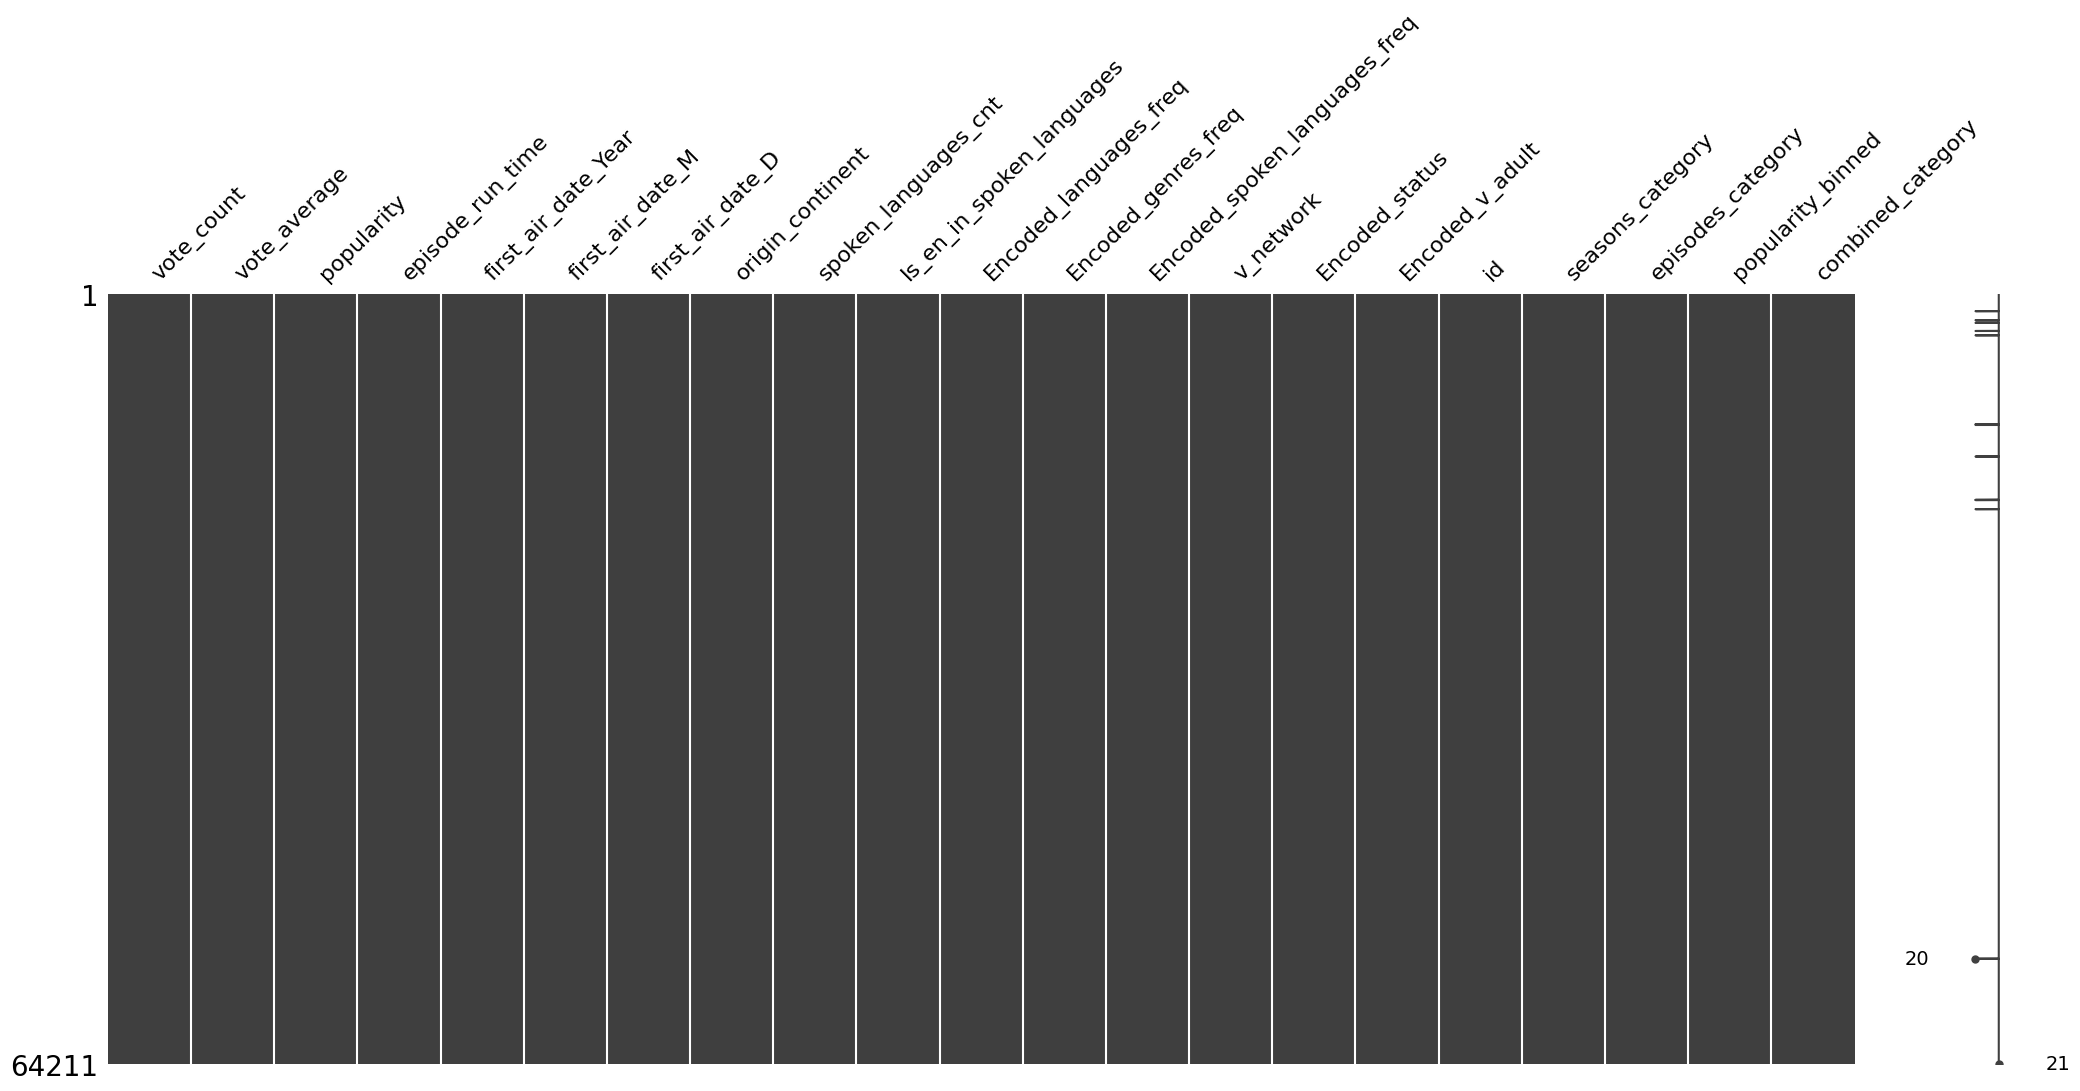

In [14]:
import missingno as msno
msno.matrix(dfload)

In [15]:

dfload['combined_category'] = dfload['combined_category'].astype('category')

# Convert the 'spoken_languages_cnt' column to 'category' type
dfload['spoken_languages_cnt'] = dfload['spoken_languages_cnt'].astype('category')
# Rename the column to add the 'Encoded ' prefix
dfload.rename(columns={'spoken_languages_cnt': 'Encoded_spoken_languages_cnt'}, inplace=True)


dfload

,vote_count,vote_average,popularity,episode_run_time,first_air_date_Year,first_air_date_M,first_air_date_D,origin_continent,Encoded_spoken_languages_cnt,Is_en_in_spoken_languages,...,Encoded_genres_freq,Encoded_spoken_languages_freq,v_network,Encoded_status,Encoded_v_adult,id,seasons_category,episodes_category,popularity_binned,combined_category
1,17836.0,8.0,96.0,70.0,2017,5,2,Europe,1.0,False,...,985,5178,Main Network,0,0,71446,3-10,10-50,0-612,3-10 & 10-50
2,16161.0,9.0,186.0,0.0,2016,7,15,North America,1.0,True,...,110,73268,Main Network,1,0,66732,3-10,10-50,0-612,3-10 & 10-50
4,13870.0,8.0,417.0,45.0,2016,1,25,North America,1.0,True,...,14,73268,Main Network,0,0,63174,3-10,50-100,0-612,3-10 & 50-100
5,13180.0,8.0,144.0,45.0,2017,1,26,North America,1.0,True,...,409,73268,Other,0,0,69050,3-10,100-500,0-612,3-10 & 100-500
6,13053.0,8.0,116.0,0.0,2021,9,17,Unknown,3.0,True,...,38,1,Main Network,1,0,93405,1-3,0-10,0-612,1-3 & 0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168630,0.0,0.0,4.0,0.0,2023,11,20,Unknown,1.0,False,...,16282,1405,Other,1,0,240293,1-3,10-50,0-612,1-3 & 10-50
168633,0.0,0.0,3.0,0.0,2023,11,30,Europe,1.0,False,...,25,7377,Other,1,0,240693,1-3,0-10,0-612,1-3 & 0-10
168634,0.0,0.0,1.0,0.0,2023,3,3,Unknown,1.0,False,...,68926,14181,Other,1,0,239099,1-3,0-10,0-612,1-3 & 0-10
168636,0.0,0.0,2.0,0.0,2023,11,30,Unknown,1.0,False,...,1037,195,Other,1,0,240696,1-3,0-10,0-612,1-3 & 0-10


In [16]:
dfload.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64211 entries, 1 to 168638
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   vote_count                     64211 non-null  float64 
 1   vote_average                   64211 non-null  float64 
 2   popularity                     64211 non-null  float64 
 3   episode_run_time               64211 non-null  float64 
 4   first_air_date_Year            64211 non-null  int64   
 5   first_air_date_M               64211 non-null  int64   
 6   first_air_date_D               64211 non-null  int64   
 7   origin_continent               64211 non-null  category
 8   Encoded_spoken_languages_cnt   64211 non-null  category
 9   Is_en_in_spoken_languages      64211 non-null  category
 10  Encoded_languages_freq         64211 non-null  int64   
 11  Encoded_genres_freq            64211 non-null  int64   
 12  Encoded_spoken_languages_freq  

In [17]:
# 1 Outlier remove

# Selecting only numeric continuous columns (excluding categorical and discrete)
# In most cases, continuous variables are numeric and float types
continuous_df = dfload.select_dtypes(include=['float64', 'int64'])
continuous_df = continuous_df.astype({col: 'float64' for col in continuous_df.select_dtypes(include='int64').columns})

# Display the small dataset with only numeric continuous data
continuous_df
continuous_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 64211 entries, 1 to 168638
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   vote_count                     64211 non-null  float64
 1   vote_average                   64211 non-null  float64
 2   popularity                     64211 non-null  float64
 3   episode_run_time               64211 non-null  float64
 4   first_air_date_Year            64211 non-null  float64
 5   first_air_date_M               64211 non-null  float64
 6   first_air_date_D               64211 non-null  float64
 7   Encoded_languages_freq         64211 non-null  float64
 8   Encoded_genres_freq            64211 non-null  float64
 9   Encoded_spoken_languages_freq  64211 non-null  float64
 10  Encoded_v_adult                64211 non-null  float64
 11  id                             64211 non-null  float64
dtypes: float64(12)
memory usage: 6.4 MB


<Axes: ylabel='popularity'>

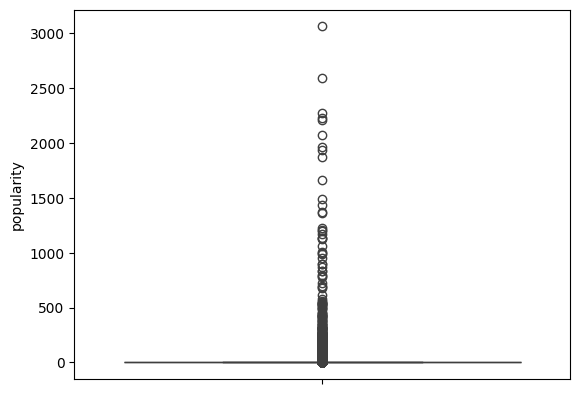

In [18]:
sns.boxplot(dfload['popularity'])

<Axes: >

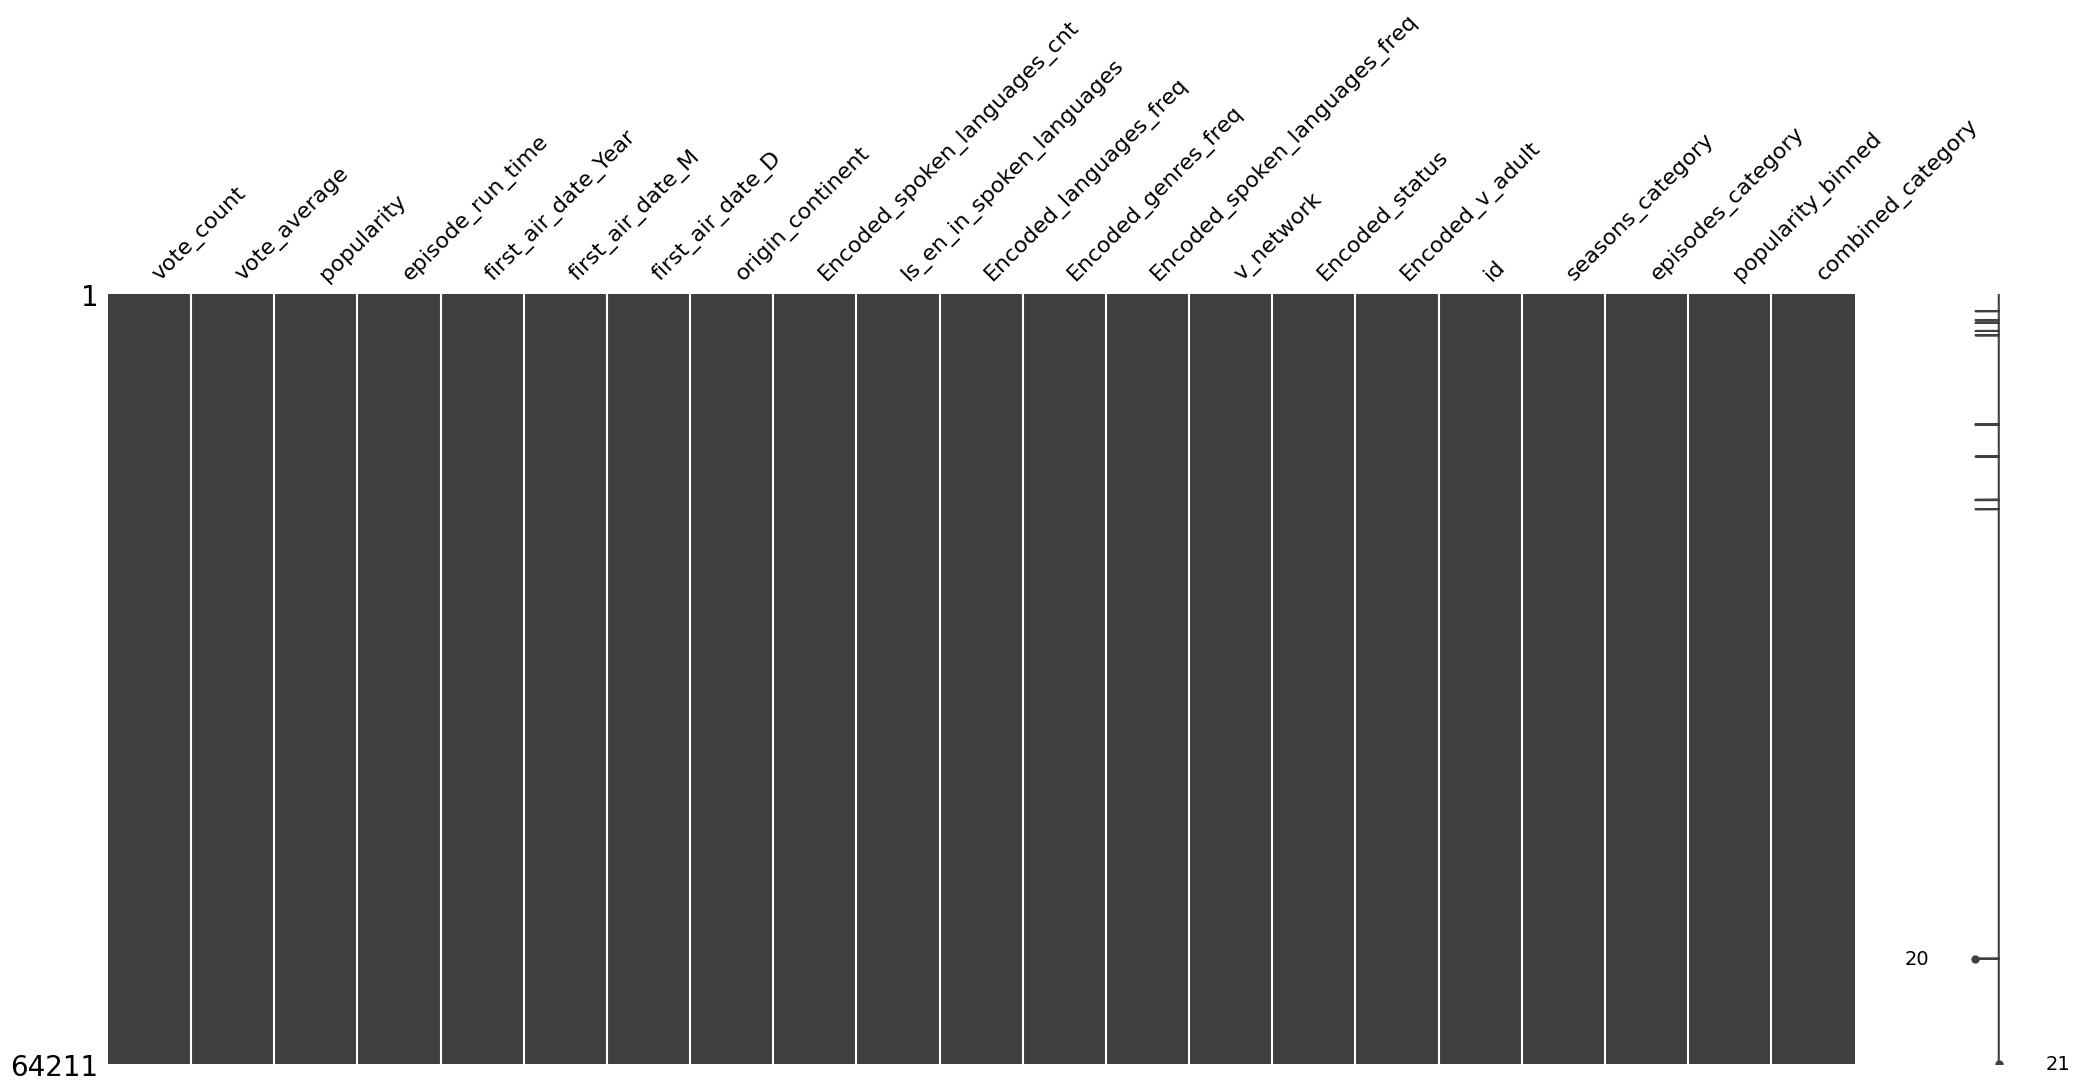

In [19]:
import missingno as msno
msno.matrix(dfload)

C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: ylabel='popularity'>

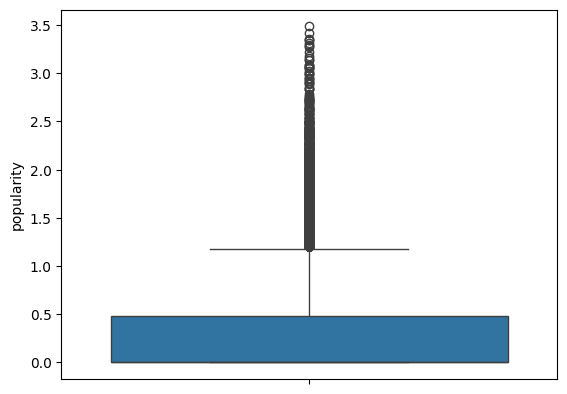

In [20]:
target_pop_log=np.log10(dfload['popularity'])
sns.boxplot(target_pop_log)

In [21]:
# Filter rows where 'popularity' is zero, negative, or NaN
filtered_df = dfload[(dfload['popularity'] <= 0) | dfload['popularity'].isna()]
print(filtered_df['popularity'].value_counts())

1/(len(dfload)/len(filtered_df))

0.0    847
Name: popularity, dtype: int64


0.013190886296740435

In [22]:
epsilon=1e-10

#Filter rows where 'popularity' is zero, negative, or NaN
filtered_df = continuous_df[(continuous_df['popularity'] <= epsilon) | continuous_df['popularity'].isna()]

# Check value counts in the filtered DataFrame
filtered_value_counts = filtered_df['popularity'].value_counts()
print(filtered_value_counts)

0.0    847
Name: popularity, dtype: int64


<Axes: >

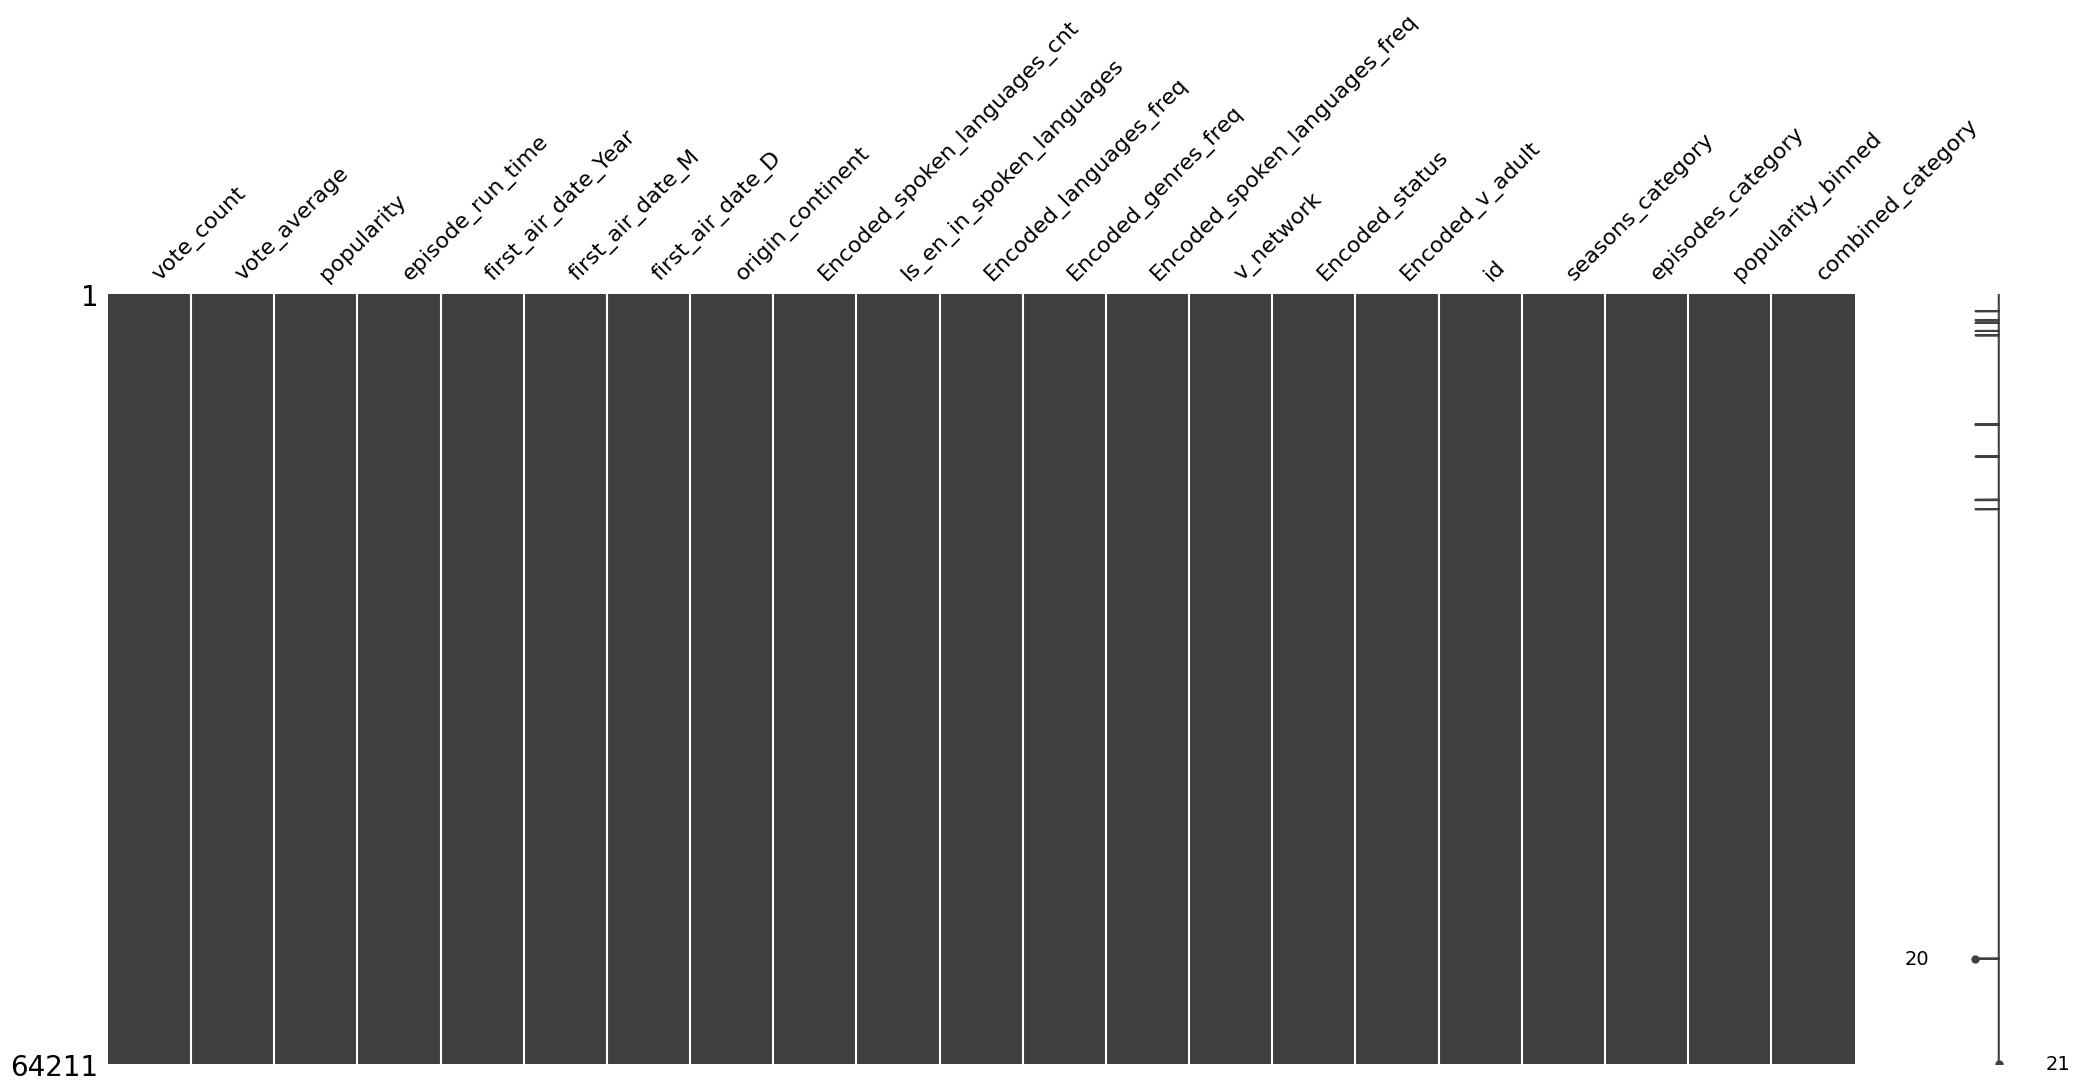

In [23]:
import missingno as msno
msno.matrix(dfload)


<Axes: >

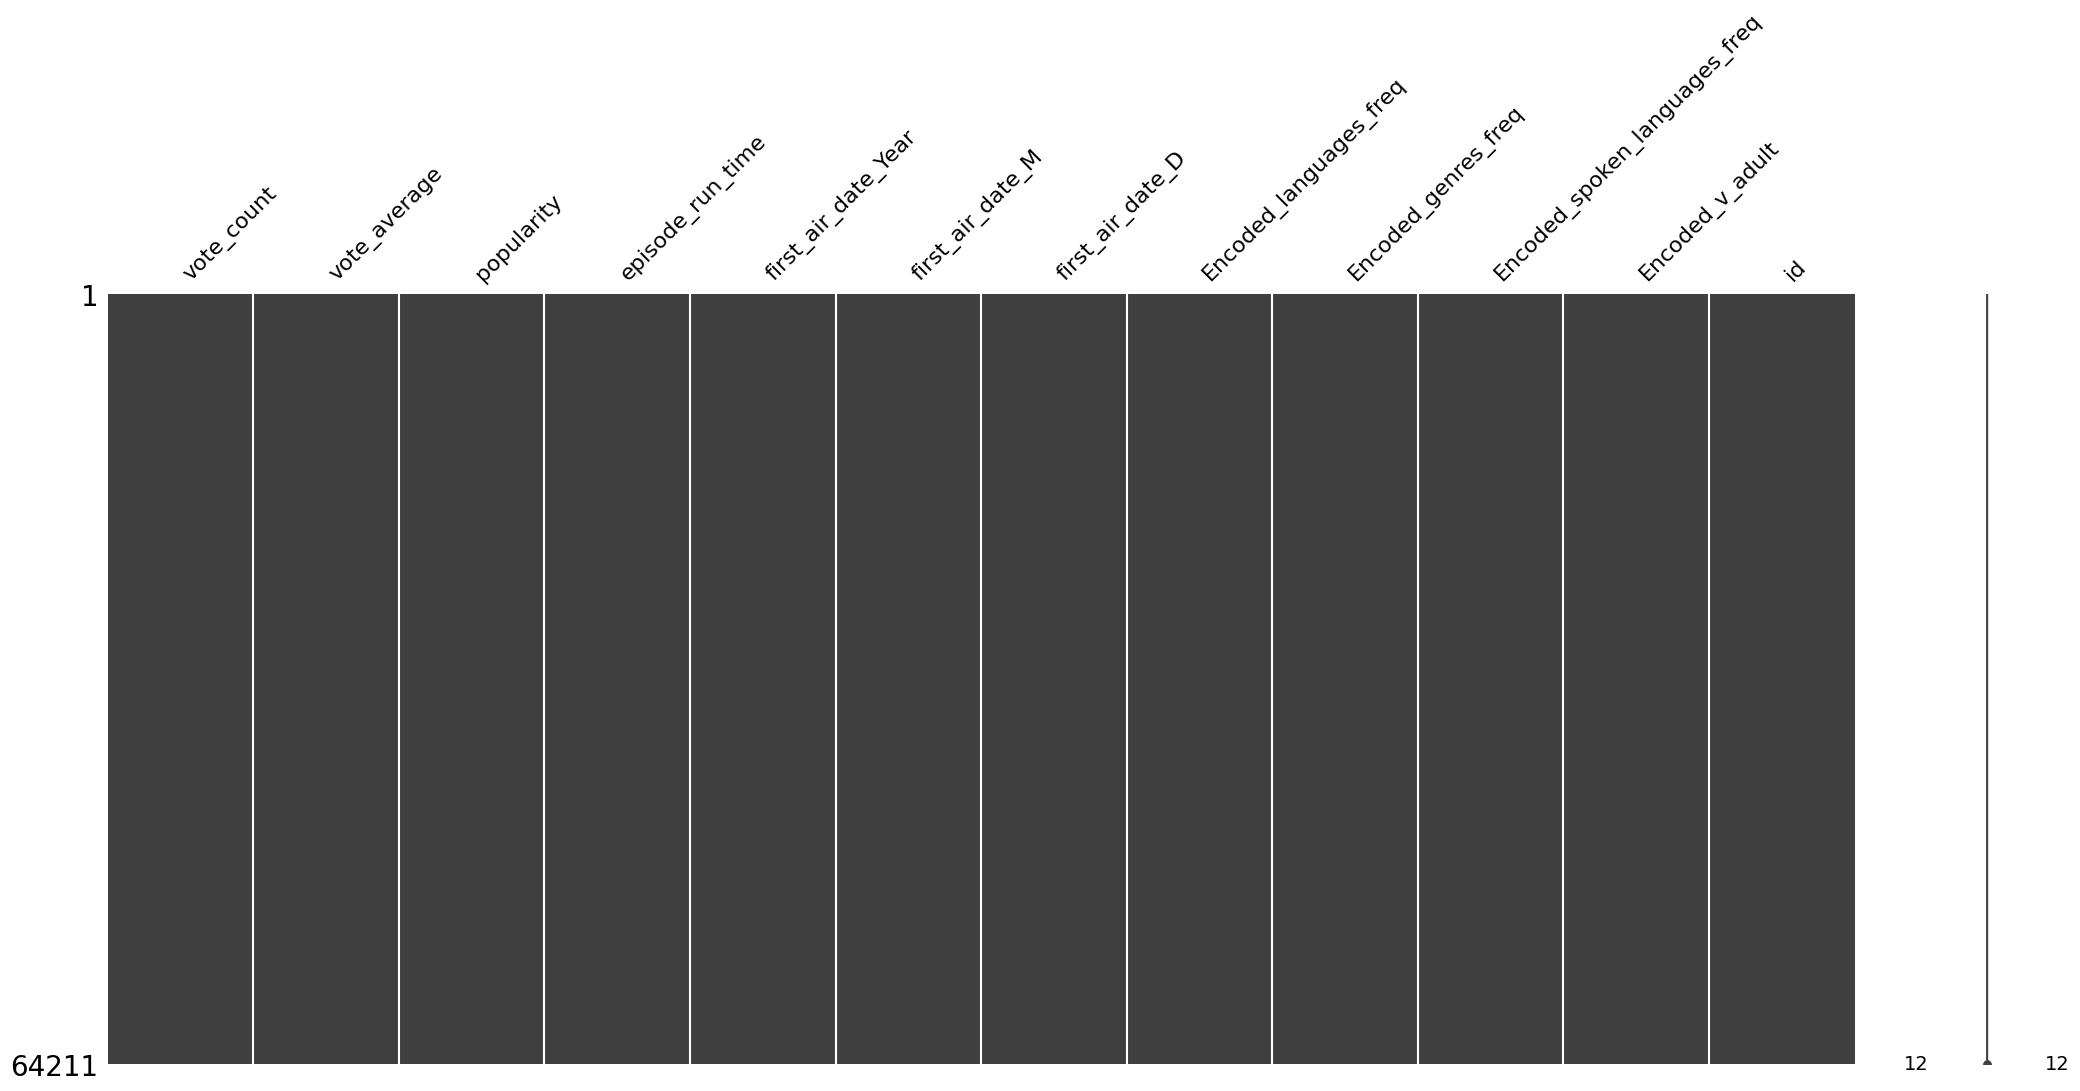

In [24]:
import missingno as msno
msno.matrix(continuous_df)

In [25]:

# Apply the function to each column and recheck
recheck_and_print(continuous_df)


print("$$$$")
# Apply the function to each column and recheck
recheck_and_print(continuous_df)






Column: vote_count
  Zeros treated: 38385
  Negatives treated: 0
  NaNs: 0

Column: vote_average
  Zeros treated: 38408
  Negatives treated: 0
  NaNs: 0

Column: popularity
  Zeros treated: 847
  Negatives treated: 0
  NaNs: 0

Column: episode_run_time
  Zeros treated: 33212
  Negatives treated: 0
  NaNs: 0

Column: first_air_date_Year
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: first_air_date_M
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: first_air_date_D
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: Encoded_languages_freq
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: Encoded_genres_freq
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: Encoded_spoken_languages_freq
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

Column: Encoded_v_adult
  Zeros treated: 64211
  Negatives treated: 0
  NaNs: 0

Column: id
  Zeros treated: 0
  Negatives treated: 0
  NaNs: 0

$$$$
Column: vote_count
  Zeros treated: 0
  Negativ

<Axes: >

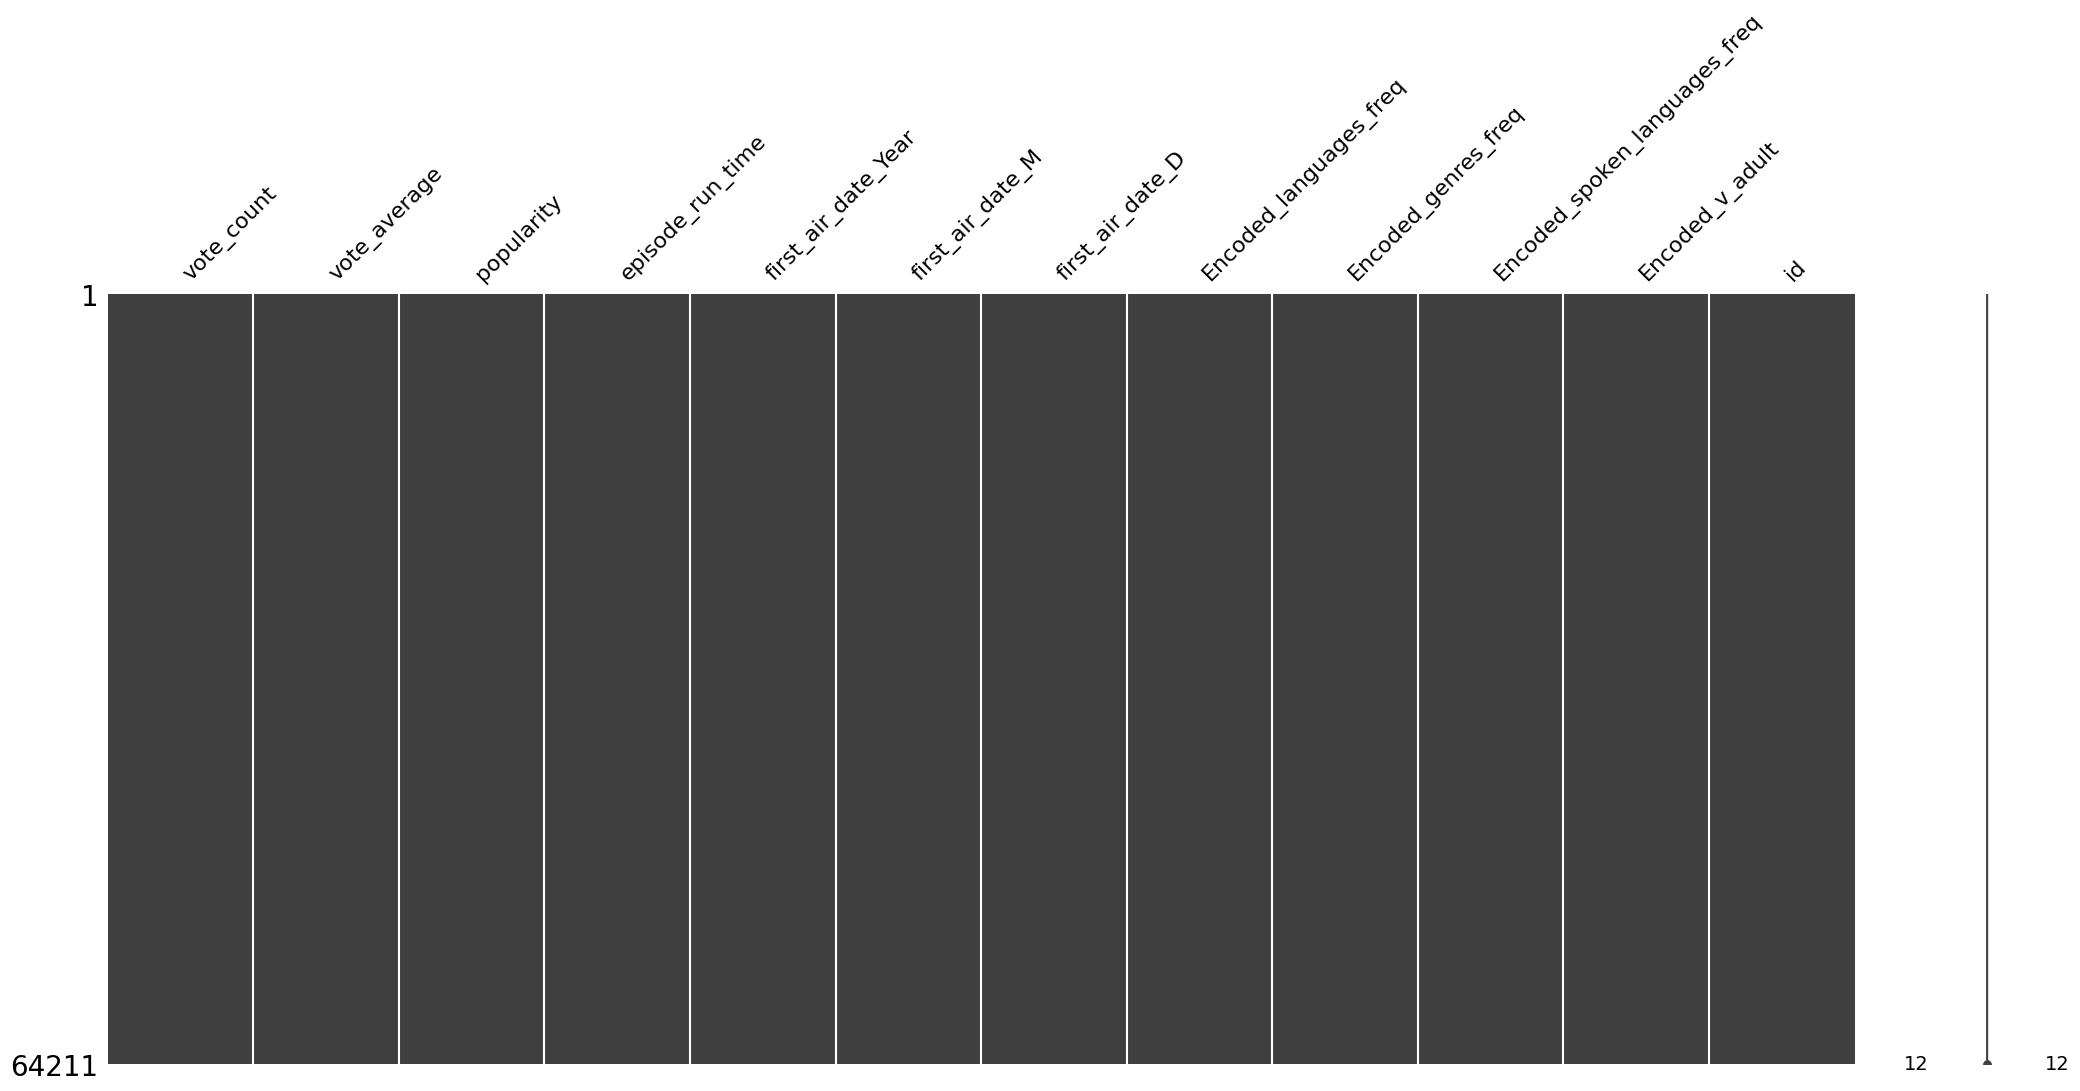

In [26]:
import missingno as msno
msno.matrix(continuous_df)   # based on whether data is missing (NaN) or present.

<Axes: ylabel='popularity'>

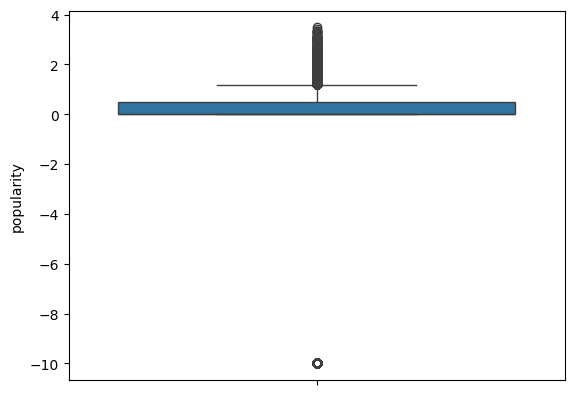

In [27]:
#Perform  log on continues 
continuous_df_log=np.log10(continuous_df)
sns.boxplot(continuous_df_log['popularity'])

In [28]:
problematic_col = 'Encoded_v_adult'  # Replace with the actual column name

# Check data type
print(f"Data type of {problematic_col}: {continuous_df[problematic_col].dtype}")

# Summary statistics
print(continuous_df[problematic_col].describe())

# Check for missing values
print(f"Missing values in {problematic_col}: {continuous_df[problematic_col].isna().sum()}")

# Display first few rows
print(continuous_df[problematic_col].head(10))

Data type of Encoded_v_adult: float64
count    6.421100e+04
mean     1.000000e-10
std      2.584960e-26
min      1.000000e-10
25%      1.000000e-10
50%      1.000000e-10
75%      1.000000e-10
max      1.000000e-10
Name: Encoded_v_adult, dtype: float64
Missing values in Encoded_v_adult: 0
1     1.000000e-10
2     1.000000e-10
4     1.000000e-10
5     1.000000e-10
6     1.000000e-10
8     1.000000e-10
9     1.000000e-10
12    1.000000e-10
14    1.000000e-10
16    1.000000e-10
Name: Encoded_v_adult, dtype: float64


In [29]:
# Function to identify and treat outliers using IQR
def treat_outliers(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:  
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)        
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
        

    ## Count the number of `1`s in each column
    count_per_column = df_outliers.apply(lambda x: (x == 1).sum())
    
    # Print the count for each column
    print("Count of `1`s per column:")
    print(count_per_column)
    
    # Sum of counts across all columns
    total_count = count_per_column.sum()
    
    #Print the count for all columns
    print("total_count of `1`s of all columns:")
    print(total_count)
                   
    return df_outliers


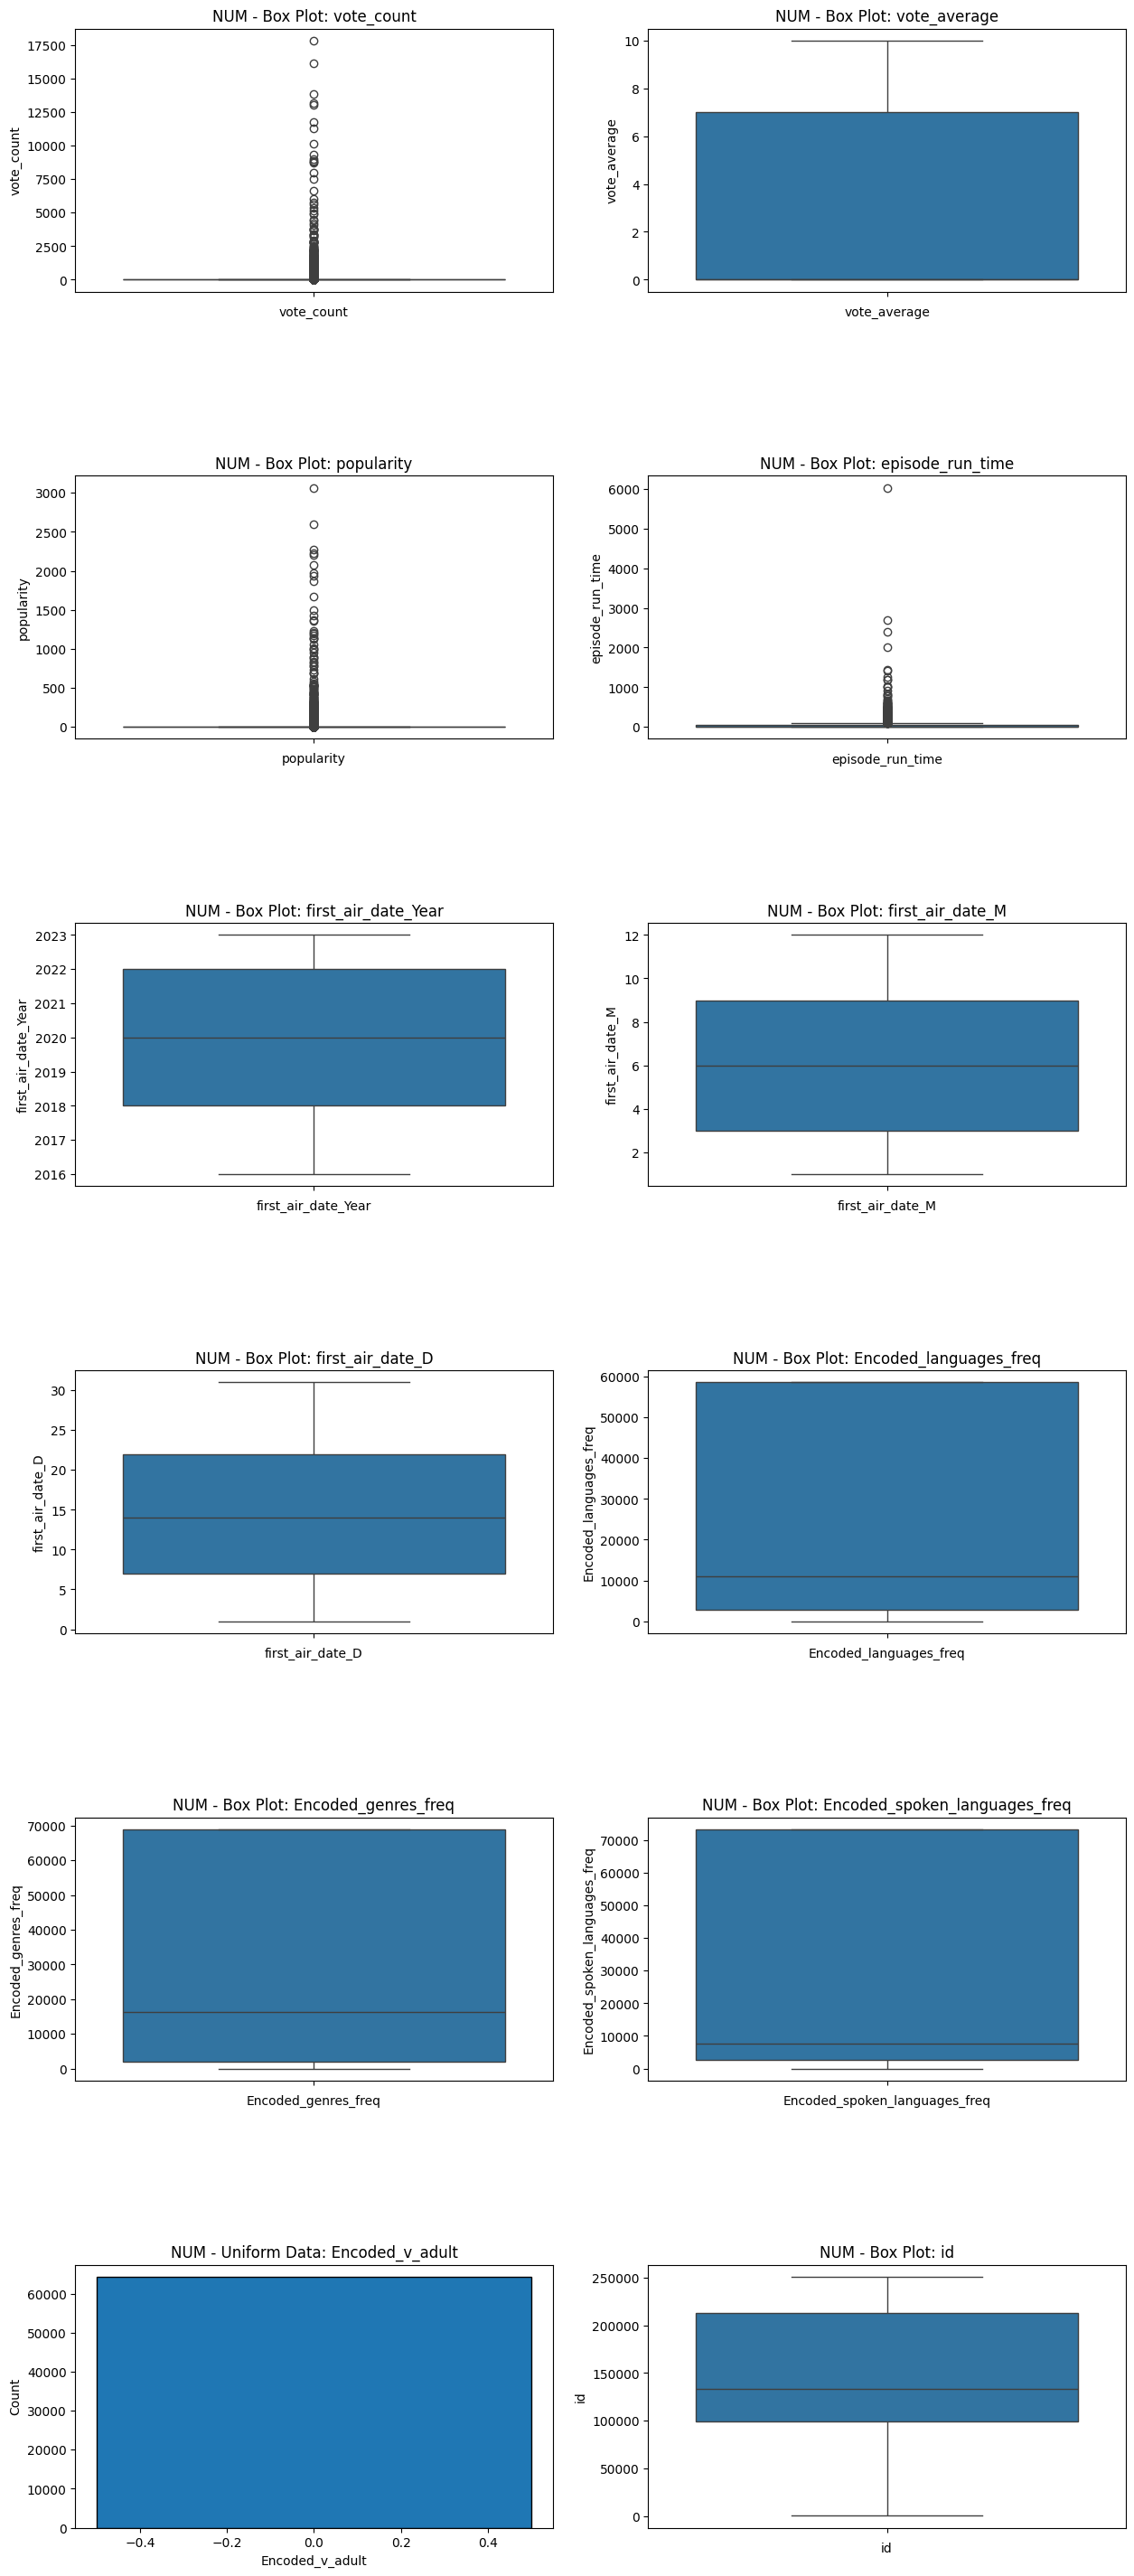

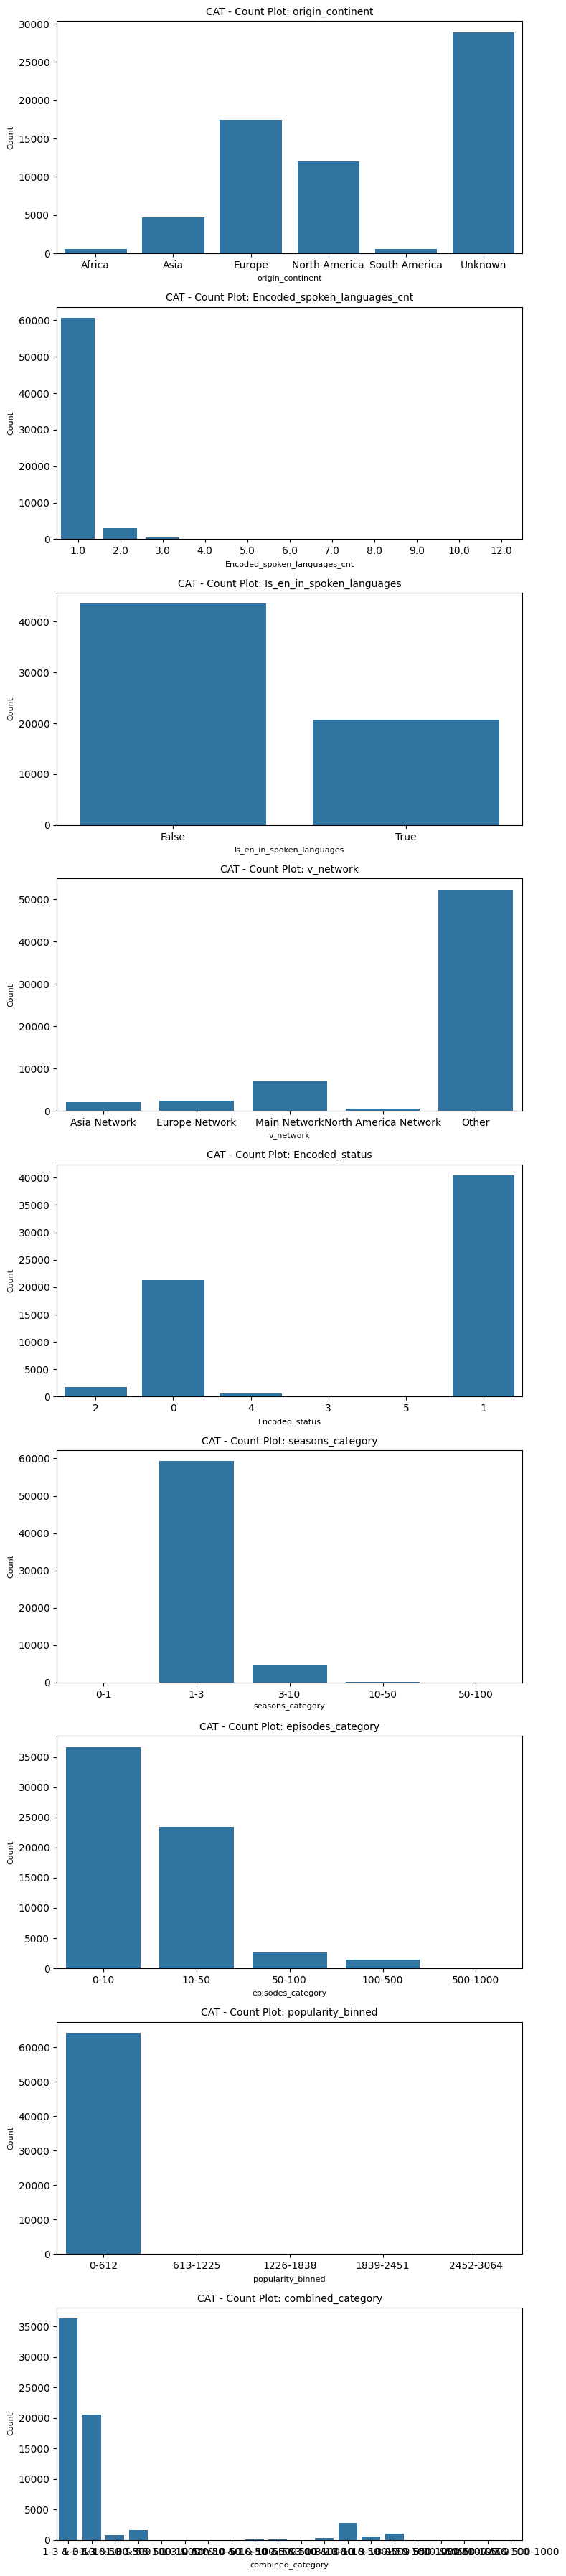

In [30]:
outliers_boxplot(dfload)


In [31]:
# Only on 3 plots on the regular plot i can see outliers: Vote_Count, poplarity, episode run time 
# below in LOg plot we cant see it.

Encoded feature shows the mean but there are no Outliers - nominal discrete
NUM means continues numeric.


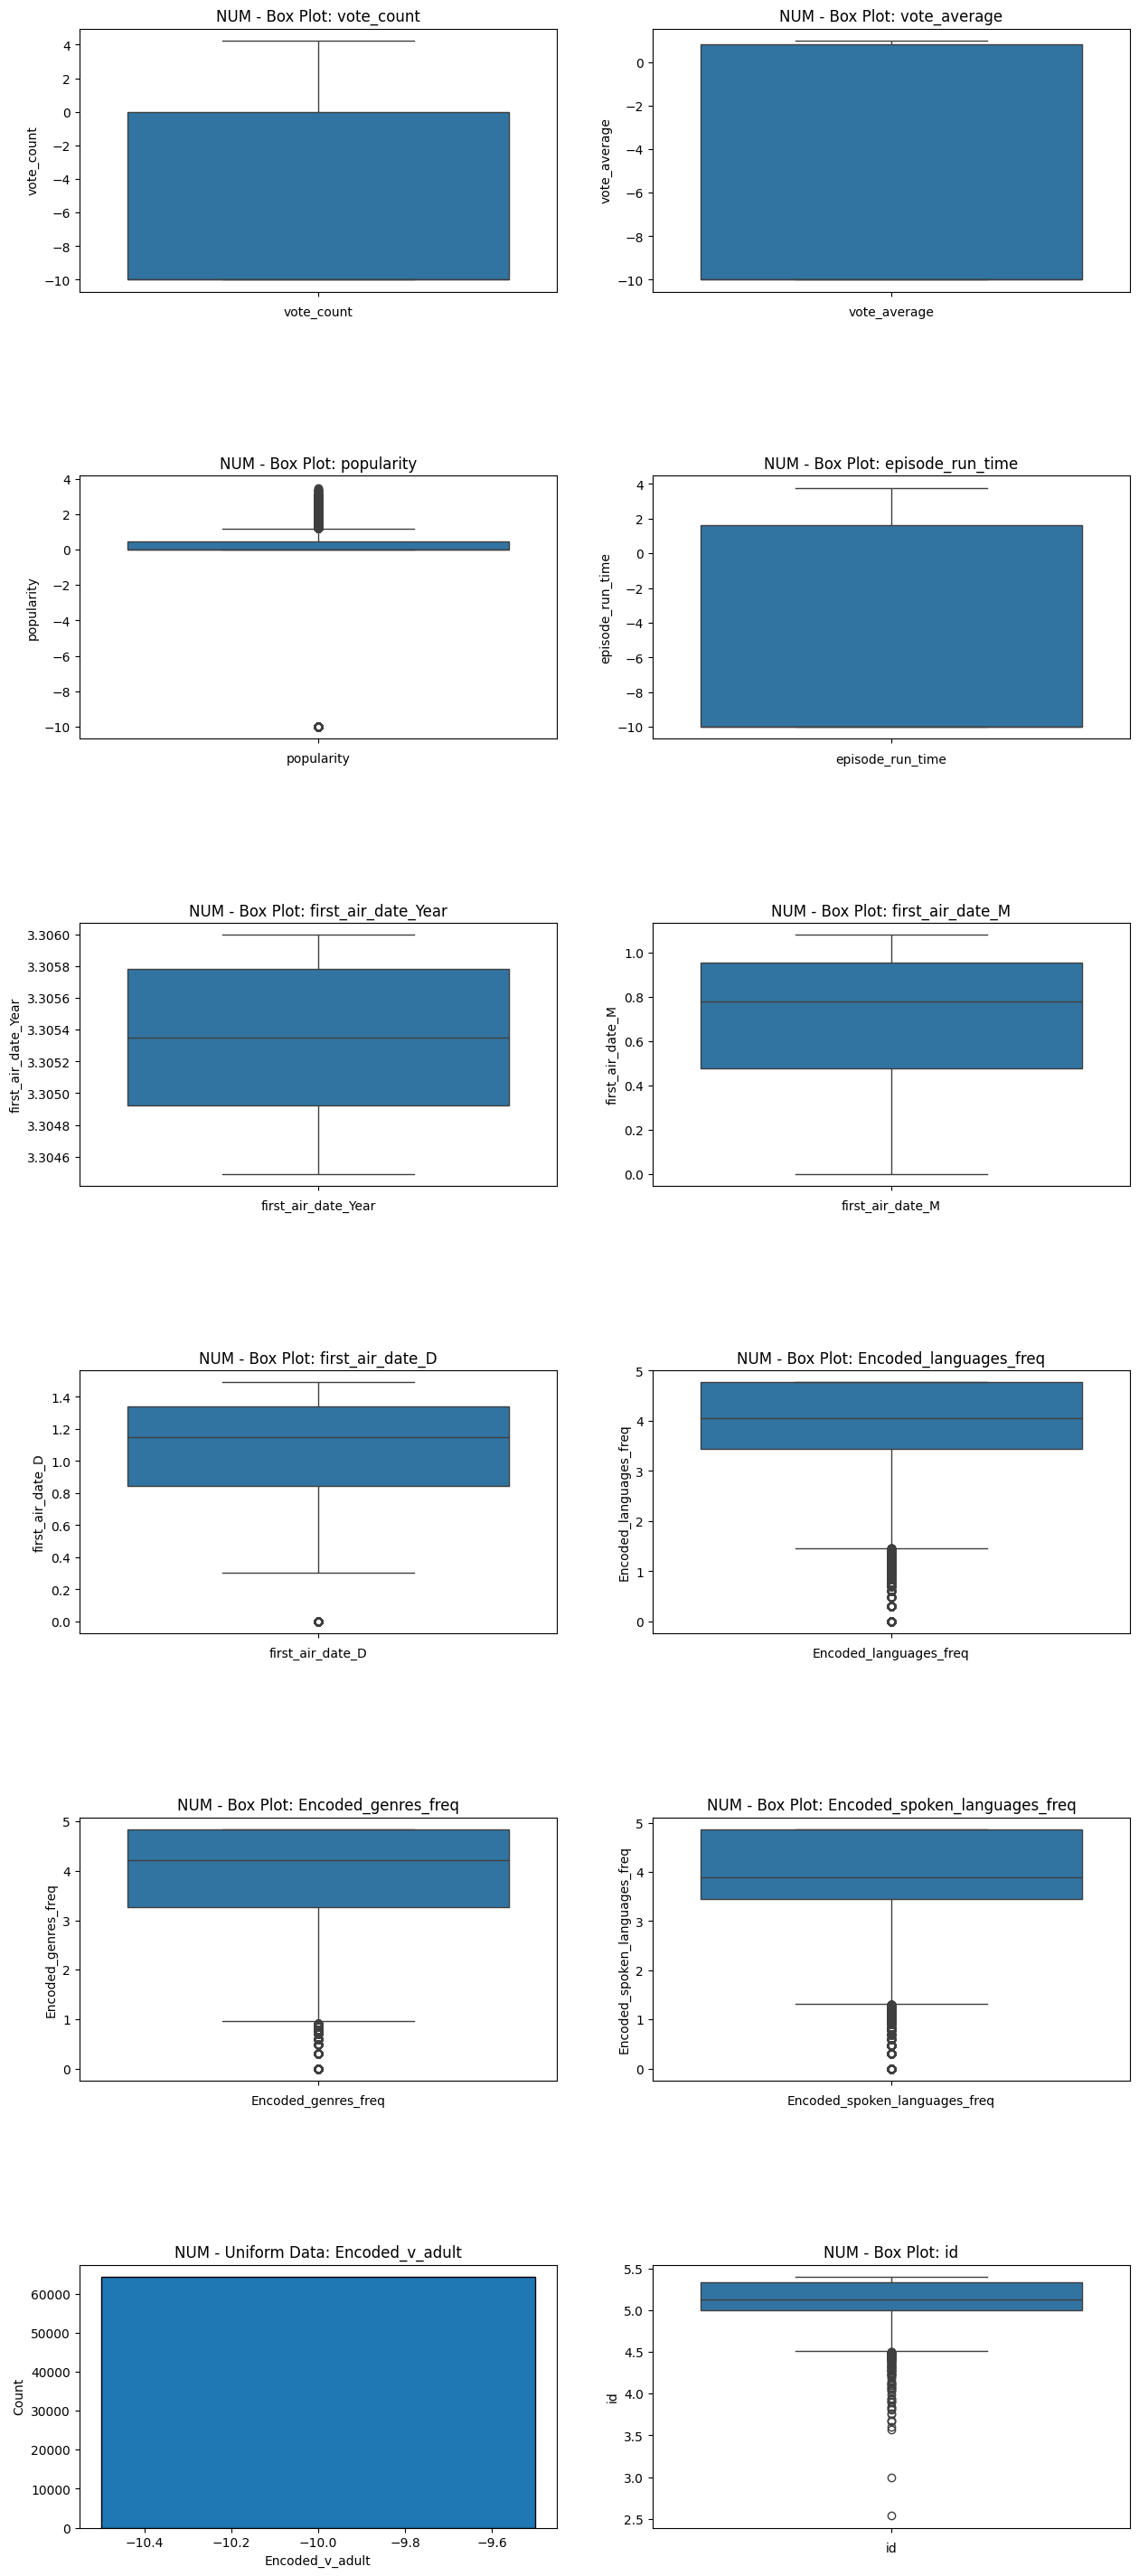

In [32]:
# Example usage with your DataFrame
outliers_boxplot(continuous_df_log)
print('Encoded feature shows the mean but there are no Outliers - nominal discrete')
print('NUM means continues numeric.')

<Axes: >

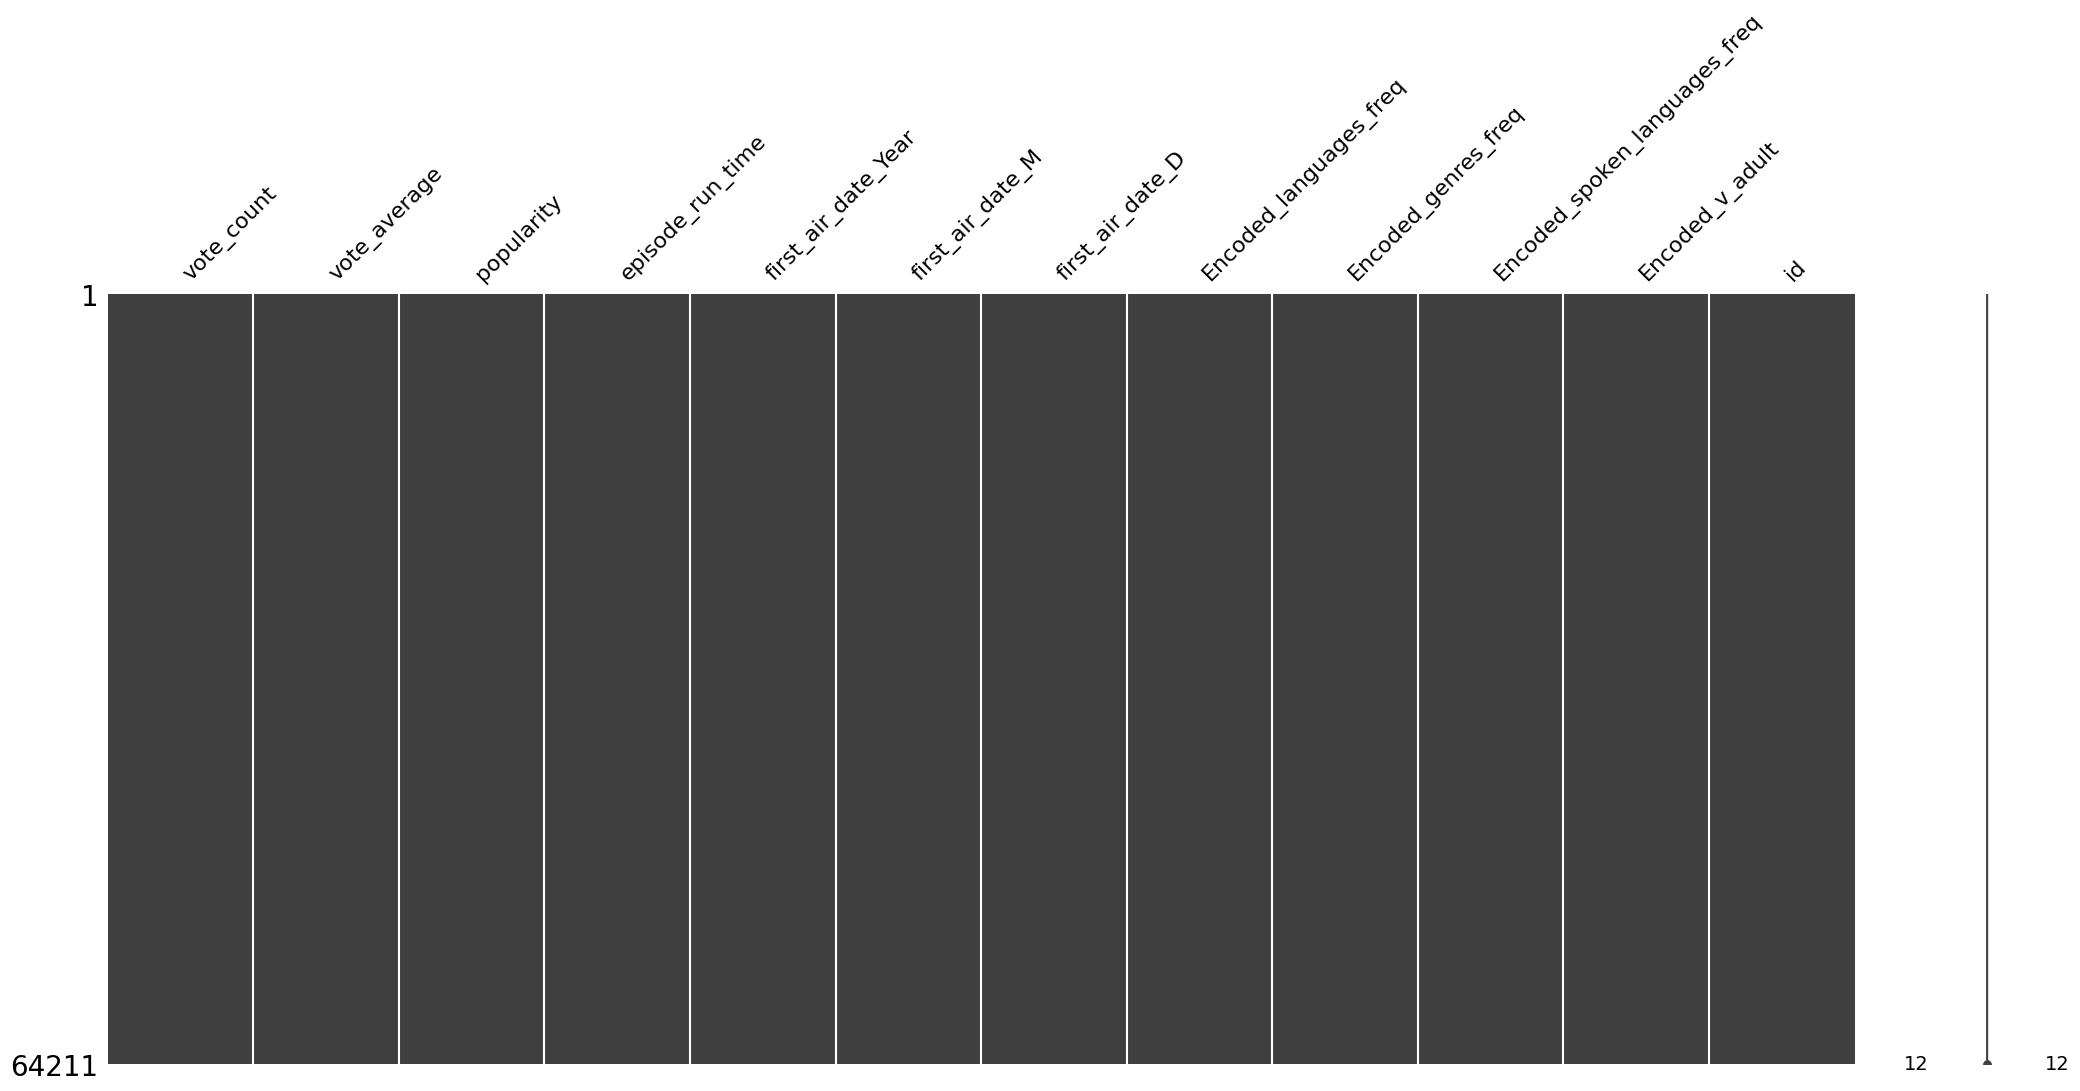

In [33]:
import missingno as msno
msno.matrix(continuous_df)   # based on whether data is missing (NaN) or present.

In [34]:
# Apply the outlier treatment function to numeric columns
outliers_df = treat_outliers(dfload, continuous_df_log)

# ihave outlier count on each column but only such outlier cell  that doesnt change the correlation but does chnage the distribution.
# as a whole outlier when removed  sharpe the distribution to such that is more normal sa it was with the outlier, based that also co doest change if it removed so it doest creat harm.
# 1 is flag for possible outlier

Count of `1`s per column:
vote_count                       12177
vote_average                         0
popularity                        8069
episode_run_time                   960
first_air_date_Year                  0
first_air_date_M                     0
first_air_date_D                     0
Encoded_languages_freq               0
Encoded_genres_freq                  0
Encoded_spoken_languages_freq        0
Encoded_v_adult                      0
id                                   0
dtype: int64
total_count of `1`s of all columns:
21206


In [35]:
continuous_df_log.columns



Index(['vote_count', 'vote_average', 'popularity', 'episode_run_time',
       'first_air_date_Year', 'first_air_date_M', 'first_air_date_D',
       'Encoded_languages_freq', 'Encoded_genres_freq',
       'Encoded_spoken_languages_freq', 'Encoded_v_adult', 'id'],
      dtype='object')

In [36]:
continuous_df.columns


Index(['vote_count', 'vote_average', 'popularity', 'episode_run_time',
       'first_air_date_Year', 'first_air_date_M', 'first_air_date_D',
       'Encoded_languages_freq', 'Encoded_genres_freq',
       'Encoded_spoken_languages_freq', 'Encoded_v_adult', 'id'],
      dtype='object')

In [37]:
outliers_df.columns


Index(['vote_count', 'vote_average', 'popularity', 'episode_run_time',
       'first_air_date_Year', 'first_air_date_M', 'first_air_date_D',
       'Encoded_languages_freq', 'Encoded_genres_freq',
       'Encoded_spoken_languages_freq', 'Encoded_v_adult', 'id'],
      dtype='object')

In [38]:
# # Checking distribution and correlation changes
# #Creating a table for outliers change
# out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
# out_df

In [39]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64211 entries, 1 to 168638
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   vote_count                     64211 non-null  int32
 1   vote_average                   64211 non-null  int32
 2   popularity                     64211 non-null  int32
 3   episode_run_time               64211 non-null  int32
 4   first_air_date_Year            64211 non-null  int32
 5   first_air_date_M               64211 non-null  int32
 6   first_air_date_D               64211 non-null  int32
 7   Encoded_languages_freq         64211 non-null  int32
 8   Encoded_genres_freq            64211 non-null  int32
 9   Encoded_spoken_languages_freq  64211 non-null  int32
 10  Encoded_v_adult                64211 non-null  int32
 11  id                             64211 non-null  int32
dtypes: int32(12)
memory usage: 3.4 MB


In [40]:
dfload.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64211 entries, 1 to 168638
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   vote_count                     64211 non-null  float64 
 1   vote_average                   64211 non-null  float64 
 2   popularity                     64211 non-null  float64 
 3   episode_run_time               64211 non-null  float64 
 4   first_air_date_Year            64211 non-null  int64   
 5   first_air_date_M               64211 non-null  int64   
 6   first_air_date_D               64211 non-null  int64   
 7   origin_continent               64211 non-null  category
 8   Encoded_spoken_languages_cnt   64211 non-null  category
 9   Is_en_in_spoken_languages      64211 non-null  category
 10  Encoded_languages_freq         64211 non-null  int64   
 11  Encoded_genres_freq            64211 non-null  int64   
 12  Encoded_spoken_languages_freq  

In [41]:
continuous_df_log.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64211 entries, 1 to 168638
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   vote_count                     64211 non-null  float64
 1   vote_average                   64211 non-null  float64
 2   popularity                     64211 non-null  float64
 3   episode_run_time               64211 non-null  float64
 4   first_air_date_Year            64211 non-null  float64
 5   first_air_date_M               64211 non-null  float64
 6   first_air_date_D               64211 non-null  float64
 7   Encoded_languages_freq         64211 non-null  float64
 8   Encoded_genres_freq            64211 non-null  float64
 9   Encoded_spoken_languages_freq  64211 non-null  float64
 10  Encoded_v_adult                64211 non-null  float64
 11  id                             64211 non-null  float64
dtypes: float64(12)
memory usage: 6.4 MB


In [42]:
# Checking distribution and correlation changes
# for col in continuous_df_log:
#     out = dfload[col]
#     non_out = dfload[col][outliers_df[col] == 0]
#     cor_out = dfload['popularity']
#     cor_non_out = dfload['popularity'][outliers_df[col] == 0]

#     # Filter out NaN values for correlation calculation
#     valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
#     valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)

#     if valid_out.sum() > 1 and valid_non_out.sum() > 1:
#         cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] -
#                                 np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
#     else:
#         cor_change = '-'

#     dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

#     new_row = pd.DataFrame({'feature': [col],
#                             'outliers_cnt': [outliers_df[col].sum()],
#                             'distribution_changed': [dist_change],
#                             'correlation_changed': [cor_change]})

#     out_df = pd.concat([out_df, new_row], ignore_index=True)

In [43]:
# Example usage
# out_df1 = process_outlier_columns_OLD(continuous_df_log, outliers_df)
# out_df1


# Example usage
try:
    features_to_drop, detailed_df = process_outlier_columns(continuous_df_log, outliers_df)
except ValueError as e:
    print(f"ValueError: {e}")


# features_to_drop

C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [44]:
detailed_df


,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,vote_count,12177,+,+,no
1,vote_average,0,-,-,no
2,popularity,8069,+,-,yes
3,episode_run_time,960,+,-,yes
4,first_air_date_Year,0,-,-,no
5,first_air_date_M,0,-,-,no
6,first_air_date_D,0,-,-,no
7,Encoded_languages_freq,0,-,-,no
8,Encoded_genres_freq,0,-,-,no
9,Encoded_spoken_languages_freq,0,-,-,no


In [45]:
features_to_drop

0          popularity
1    episode_run_time
Name: feature, dtype: object

In [46]:
# # Add the 'drop' column based on the specified conditions
# out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')

# # Filter features where only distribution changes but not correlation
# to_drop = out_df[out_df['drop'] == 'yes']['feature']

# # Display the resulting DataFrame
# out_df

<Axes: >

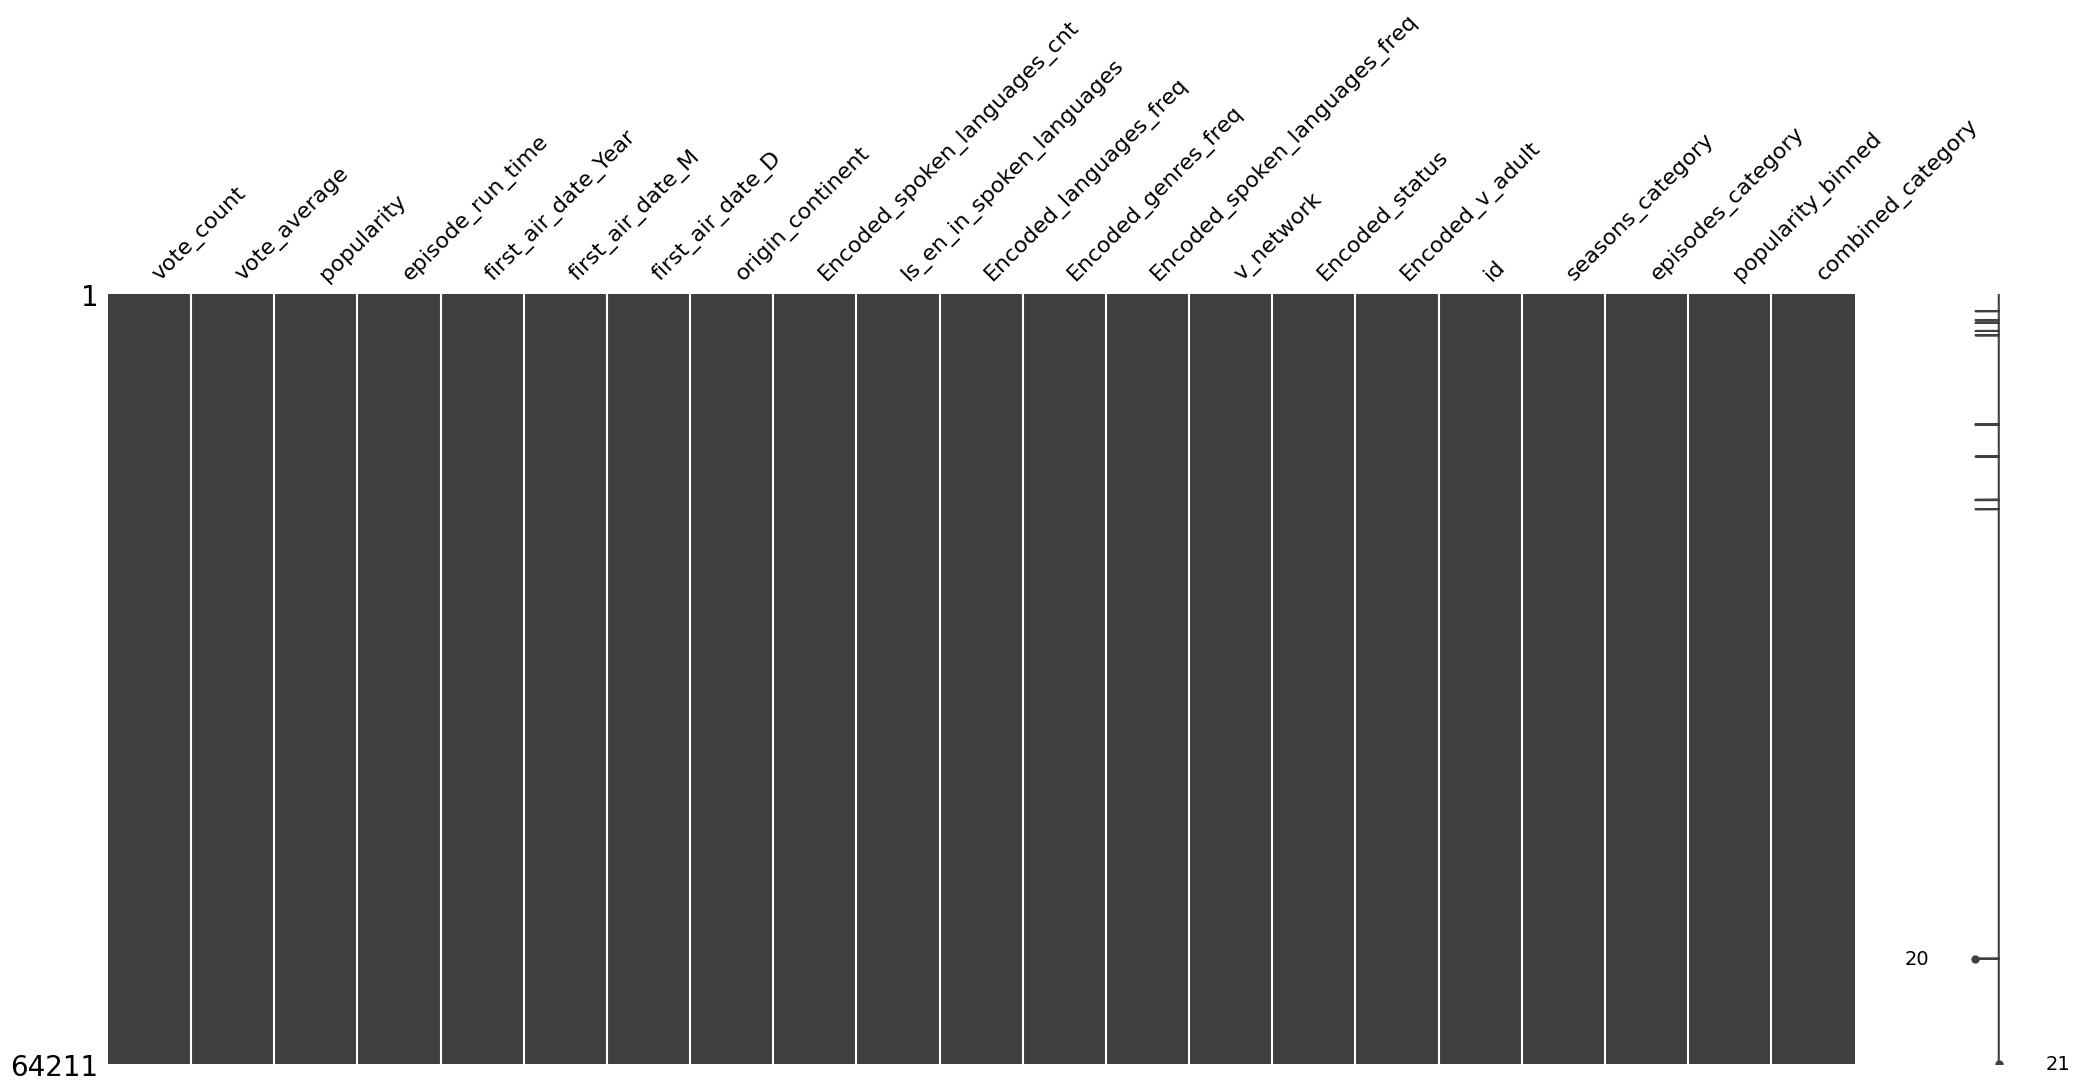

In [47]:
msno.matrix(dfload)

In [48]:
### Look here                            @GGGGGGGGGGGGGYYYYYYYYY

In [49]:
# Remove outliers
#Clean outliers as long a it is not target value popularity
i=0
for col in features_to_drop:
    if col != 'popularity' or col != 'id':  # Check to ensure the column is not 'popularity'
        i+=1
        cntnan = outliers_df[col].sum()
        print(f"remove outlier and implement nan instead for:{col} in dfload count:{cntnan}. process counter{i}" )
        dfload.loc[outliers_df[col] == 1, col] = np.nan

# Display the updated df_cleaned
dfload

remove outlier and implement nan instead for:popularity in dfload count:8069. process counter1
remove outlier and implement nan instead for:episode_run_time in dfload count:960. process counter2


,vote_count,vote_average,popularity,episode_run_time,first_air_date_Year,first_air_date_M,first_air_date_D,origin_continent,Encoded_spoken_languages_cnt,Is_en_in_spoken_languages,...,Encoded_genres_freq,Encoded_spoken_languages_freq,v_network,Encoded_status,Encoded_v_adult,id,seasons_category,episodes_category,popularity_binned,combined_category
1,17836.0,8.0,NaN,70.0,2017,5,2,Europe,1.0,False,...,985,5178,Main Network,0,0,71446,3-10,10-50,0-612,3-10 & 10-50
2,16161.0,9.0,NaN,0.0,2016,7,15,North America,1.0,True,...,110,73268,Main Network,1,0,66732,3-10,10-50,0-612,3-10 & 10-50
4,13870.0,8.0,NaN,45.0,2016,1,25,North America,1.0,True,...,14,73268,Main Network,0,0,63174,3-10,50-100,0-612,3-10 & 50-100
5,13180.0,8.0,NaN,45.0,2017,1,26,North America,1.0,True,...,409,73268,Other,0,0,69050,3-10,100-500,0-612,3-10 & 100-500
6,13053.0,8.0,NaN,0.0,2021,9,17,Unknown,3.0,True,...,38,1,Main Network,1,0,93405,1-3,0-10,0-612,1-3 & 0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168630,0.0,0.0,4.0,0.0,2023,11,20,Unknown,1.0,False,...,16282,1405,Other,1,0,240293,1-3,10-50,0-612,1-3 & 10-50
168633,0.0,0.0,3.0,0.0,2023,11,30,Europe,1.0,False,...,25,7377,Other,1,0,240693,1-3,0-10,0-612,1-3 & 0-10
168634,0.0,0.0,1.0,0.0,2023,3,3,Unknown,1.0,False,...,68926,14181,Other,1,0,239099,1-3,0-10,0-612,1-3 & 0-10
168636,0.0,0.0,2.0,0.0,2023,11,30,Unknown,1.0,False,...,1037,195,Other,1,0,240696,1-3,0-10,0-612,1-3 & 0-10


<Axes: >

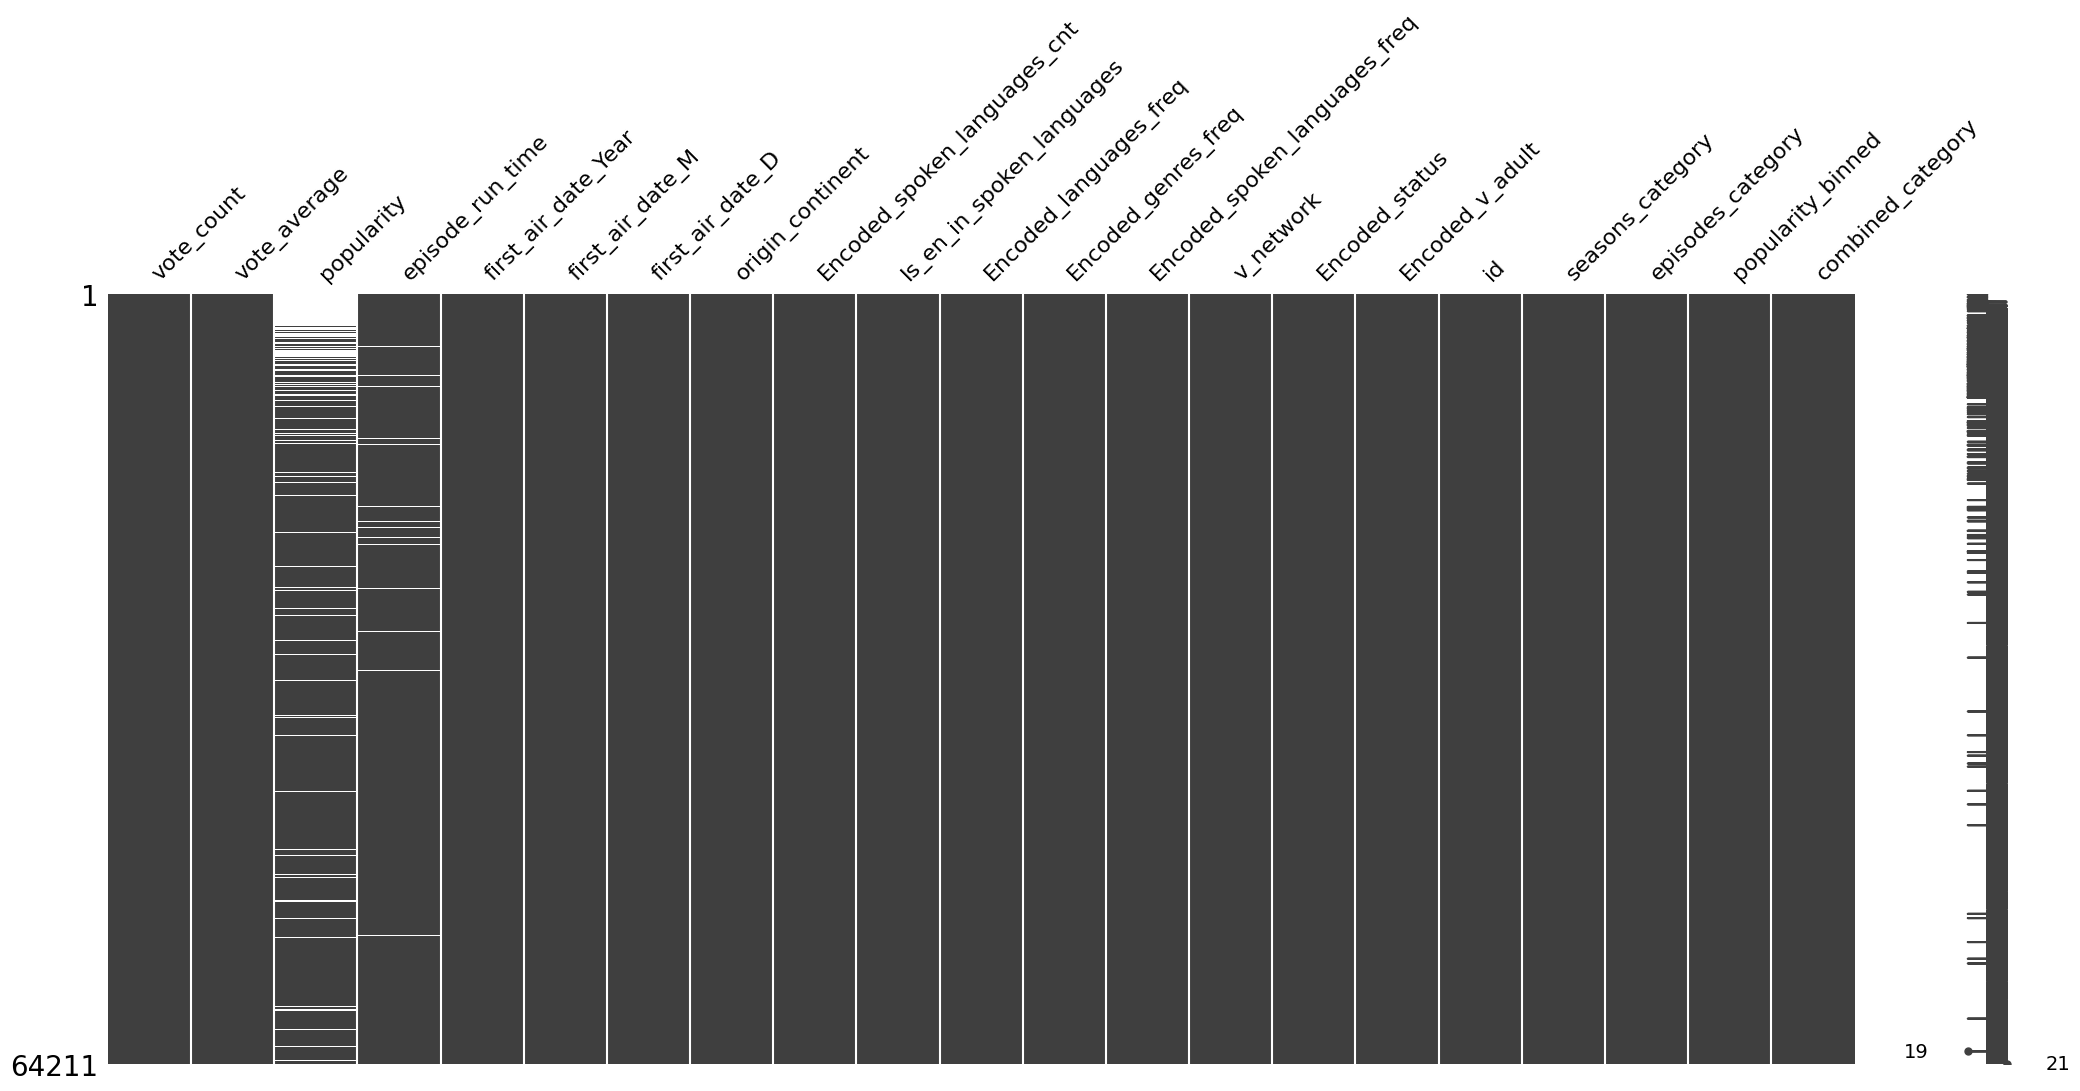

In [50]:
msno.matrix(dfload)

In [51]:
# Create a new column with adjusted categories
# dfload['v_network_adjusted'] = dfload['v_network'].apply(lambda x: x if x != 'Other' else 'Nan')
# dfload
# Drop the 'v_network_adjusted' column
#dfload = dfload.drop(columns=['v_network_adjusted'])

In [52]:
calculate_statistics(dfload, 'popularity', 1e-10)

Statistics for column 'popularity':
Count of NaN values: 8069
Count of 0 values: 847
Count of values equal to epsilon (1e-10): 0


In [53]:
# Apply the function It should be in the cleaning phase - apply here after one of the graph here revael it 
df_cleaned = drop_zero_or_epsilon(dfload, 'popularity', epsilon)

Number of rows before dropping: 64211
Number of rows after dropping: 63364


In [54]:
calculate_statistics(df_cleaned, 'popularity', 1e-10)

Statistics for column 'popularity':
Count of NaN values: 8069
Count of 0 values: 0
Count of values equal to epsilon (1e-10): 0


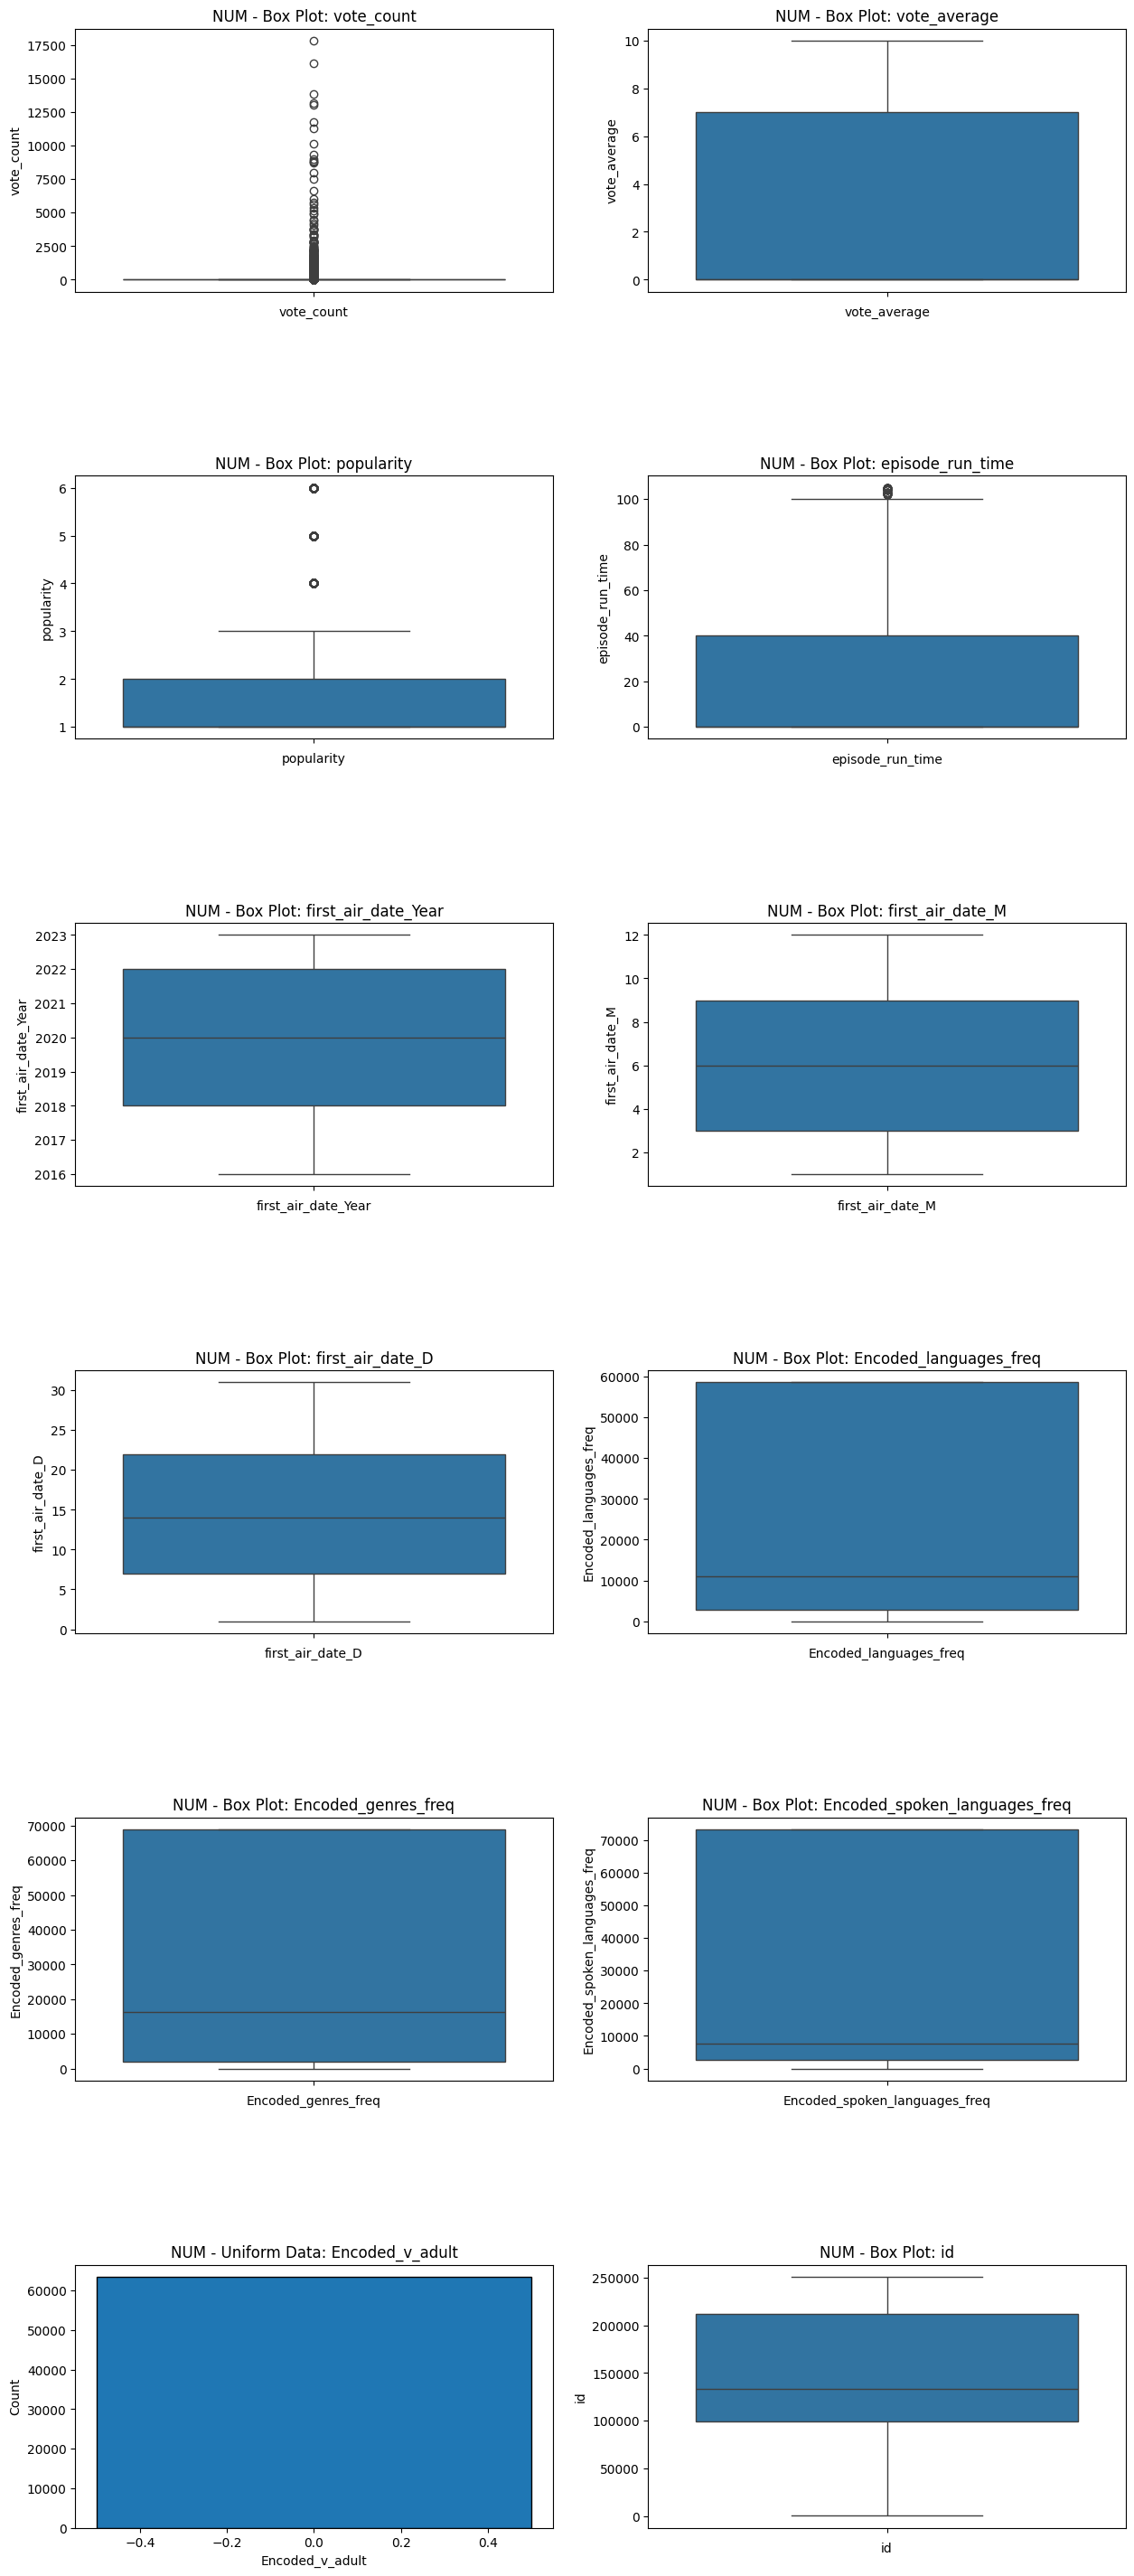

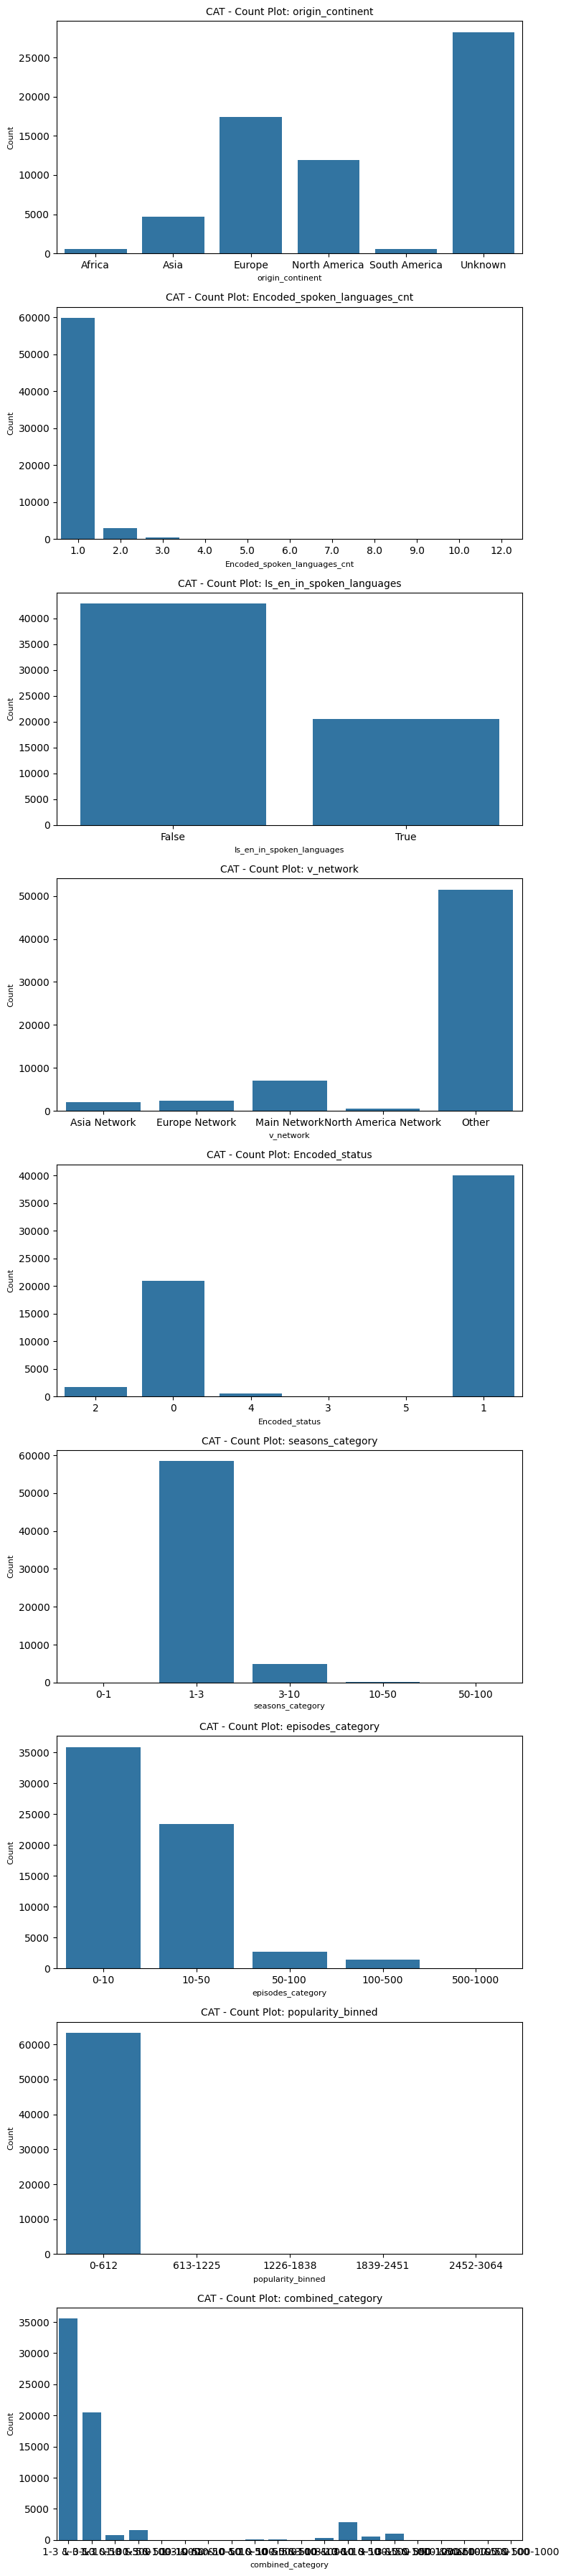

Encoded feature shows the mean but there are no Outliers - nominal discrete
NUM means numeric continues.


In [55]:
# Example usage with your DataFrame - see again the results after outlier removal
# dfload was cleaned from outliers instead  set as Nan on each outlier cell
outliers_boxplot(df_cleaned)
print('Encoded feature shows the mean but there are no Outliers - nominal discrete')
print('NUM means numeric continues.')

In [56]:
# Save cleaned data - clean from outlier and clean forom popularity =0
df_cleaned.to_pickle('df_cleanedfromoutlier.pkl')

In [57]:
import pandas as pd
#load from pickle 
dfload1 = pd.read_pickle('df_cleanedfromoutlier.pkl')

<Axes: >

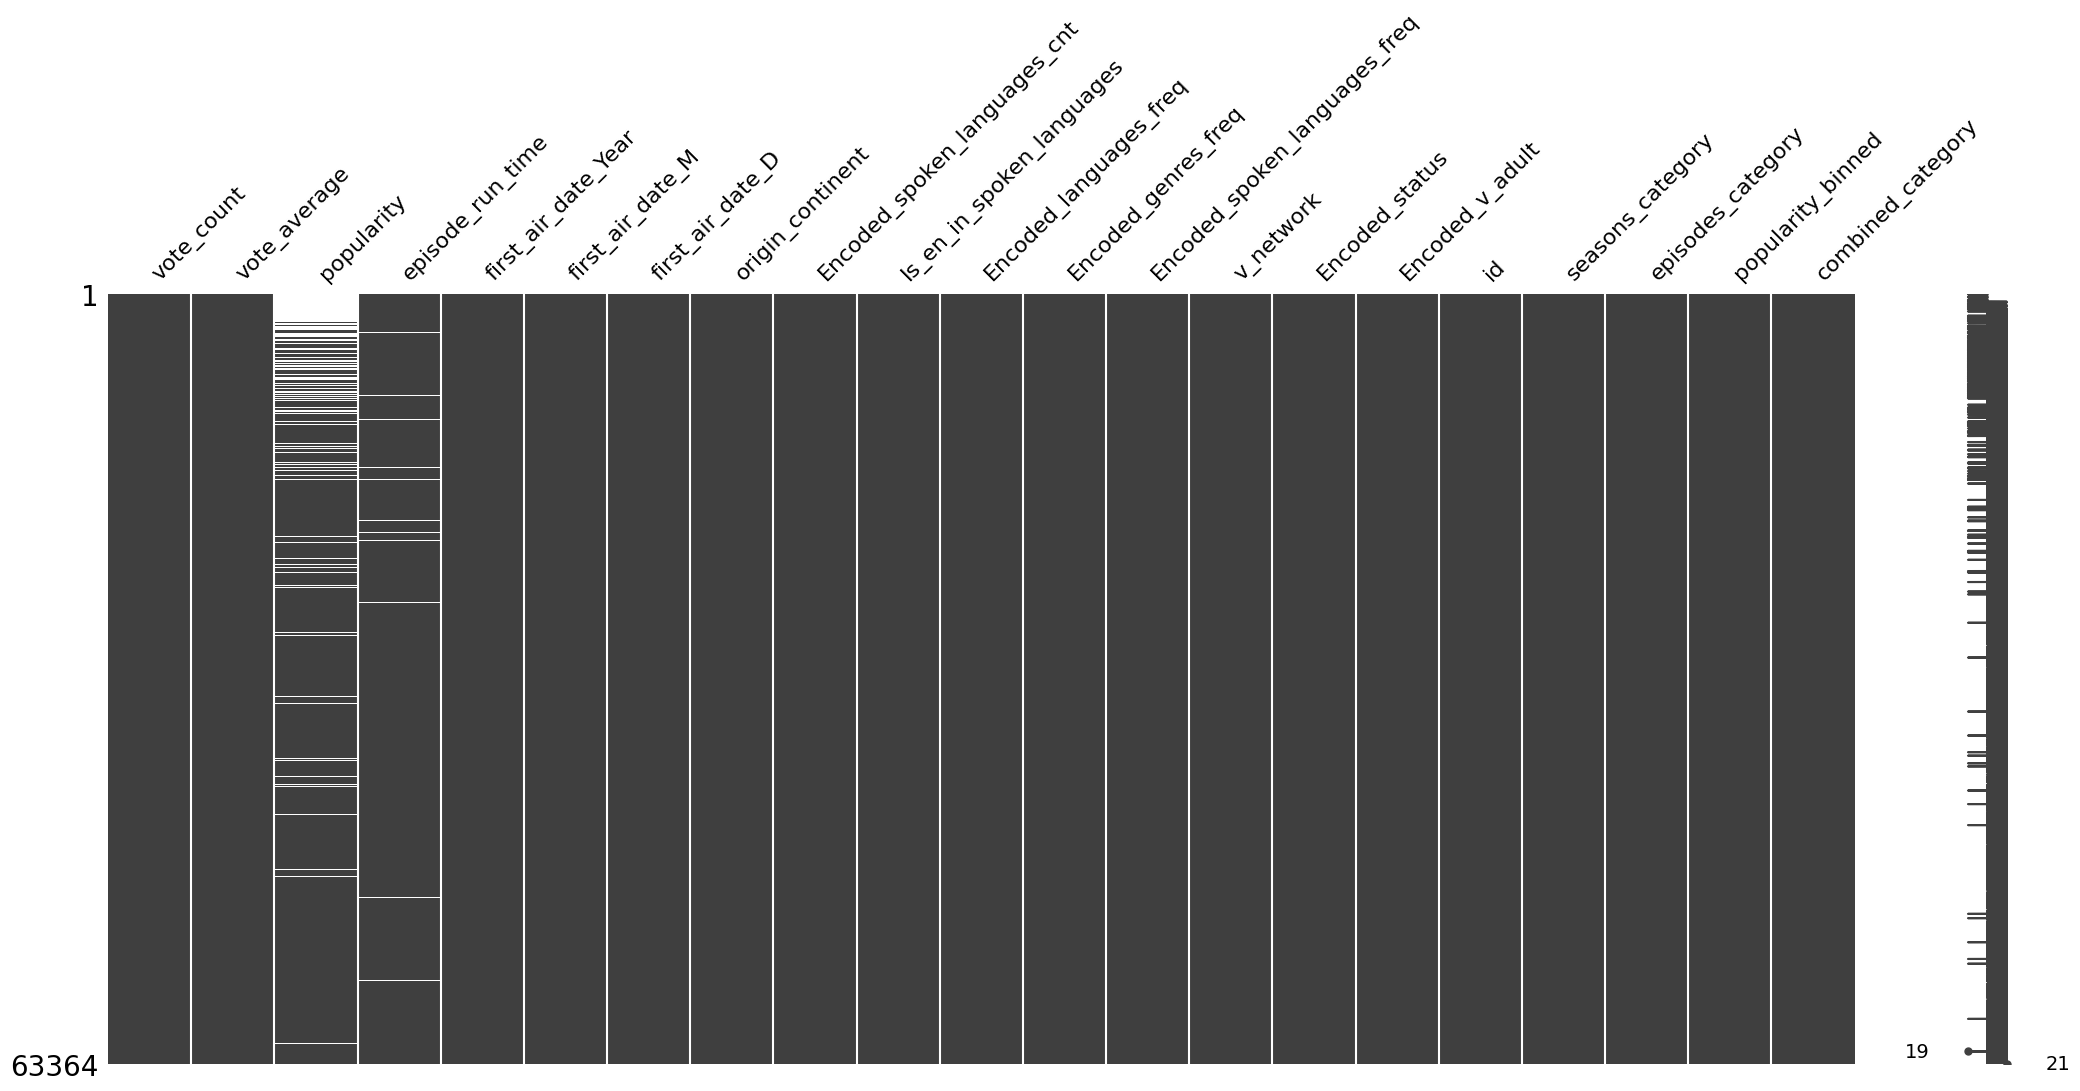

In [58]:
                                       #  Missing Data   #

# 2 Imputation  KNN


import missingno as msno
msno.matrix(dfload1)

In [59]:
print(dfload1.columns)

Index(['vote_count', 'vote_average', 'popularity', 'episode_run_time',
       'first_air_date_Year', 'first_air_date_M', 'first_air_date_D',
       'origin_continent', 'Encoded_spoken_languages_cnt',
       'Is_en_in_spoken_languages', 'Encoded_languages_freq',
       'Encoded_genres_freq', 'Encoded_spoken_languages_freq', 'v_network',
       'Encoded_status', 'Encoded_v_adult', 'id', 'seasons_category',
       'episodes_category', 'popularity_binned', 'combined_category'],
      dtype='object')


In [62]:
print(dfload1.dtypes)

vote_count                        float64
vote_average                      float64
popularity                        float64
episode_run_time                  float64
first_air_date_Year                 int64
first_air_date_M                    int64
first_air_date_D                    int64
origin_continent                 category
Encoded_spoken_languages_cnt     category
Is_en_in_spoken_languages        category
Encoded_languages_freq              int64
Encoded_genres_freq                 int64
Encoded_spoken_languages_freq       int64
v_network                        category
Encoded_status                   category
Encoded_v_adult                     int64
id                                  int64
seasons_category                 category
episodes_category                category
popularity_binned                category
combined_category                category
dtype: object


In [89]:
# Impute missing values
df_imputed = knn_impute1(dfload1, 'popularity')
#knn_impute_preserve_dtypes
df_imputed


Before Imputation
Shape: (63364, 21)
Column Types:
vote_count                        float64
vote_average                      float64
popularity                        float64
episode_run_time                  float64
first_air_date_Year                 int64
first_air_date_M                    int64
first_air_date_D                    int64
origin_continent                 category
Encoded_spoken_languages_cnt     category
Is_en_in_spoken_languages        category
Encoded_languages_freq              int64
Encoded_genres_freq                 int64
Encoded_spoken_languages_freq       int64
v_network                        category
Encoded_status                   category
Encoded_v_adult                     int64
id                                  int64
seasons_category                 category
episodes_category                category
popularity_binned                category
combined_category                category
dtype: object

After Imputation
Shape: (63364, 21)
Column Types:
vo

,vote_count,vote_average,episode_run_time,first_air_date_Year,first_air_date_M,first_air_date_D,Encoded_languages_freq,Encoded_genres_freq,Encoded_spoken_languages_freq,Encoded_v_adult,...,origin_continent,Encoded_spoken_languages_cnt,Is_en_in_spoken_languages,v_network,Encoded_status,seasons_category,episodes_category,popularity_binned,combined_category,popularity
0,17836.0,8.0,70.0,2017,5,2,3853,985,5178,0,...,Europe,1.0,False,Main Network,0,3-10,10-50,0-612,3-10 & 10-50,NaN
1,16161.0,9.0,0.0,2016,7,15,38671,110,73268,0,...,North America,1.0,True,Main Network,1,3-10,10-50,0-612,3-10 & 10-50,NaN
2,13870.0,8.0,45.0,2016,1,25,38671,14,73268,0,...,North America,1.0,True,Main Network,0,3-10,50-100,0-612,3-10 & 50-100,NaN
3,13180.0,8.0,45.0,2017,1,26,38671,409,73268,0,...,North America,1.0,True,Other,0,3-10,100-500,0-612,3-10 & 100-500,NaN
4,13053.0,8.0,0.0,2021,9,17,1,38,1,0,...,Unknown,3.0,True,Main Network,1,1-3,0-10,0-612,1-3 & 0-10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63359,0.0,0.0,0.0,2023,11,20,1421,16282,1405,0,...,Unknown,1.0,False,Other,1,1-3,10-50,0-612,1-3 & 10-50,4.0
63360,0.0,0.0,0.0,2023,11,30,6204,25,7377,0,...,Europe,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,3.0
63361,0.0,0.0,0.0,2023,3,3,58589,68926,14181,0,...,Unknown,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,1.0
63362,0.0,0.0,0.0,2023,11,30,199,1037,195,0,...,Unknown,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,2.0


In [63]:
calculate_statistics(dfload1, 'popularity', 1e-10)


Statistics for column 'popularity':
Count of NaN values: 8069
Count of 0 values: 0
Count of values equal to epsilon (1e-10): 0


<Axes: >

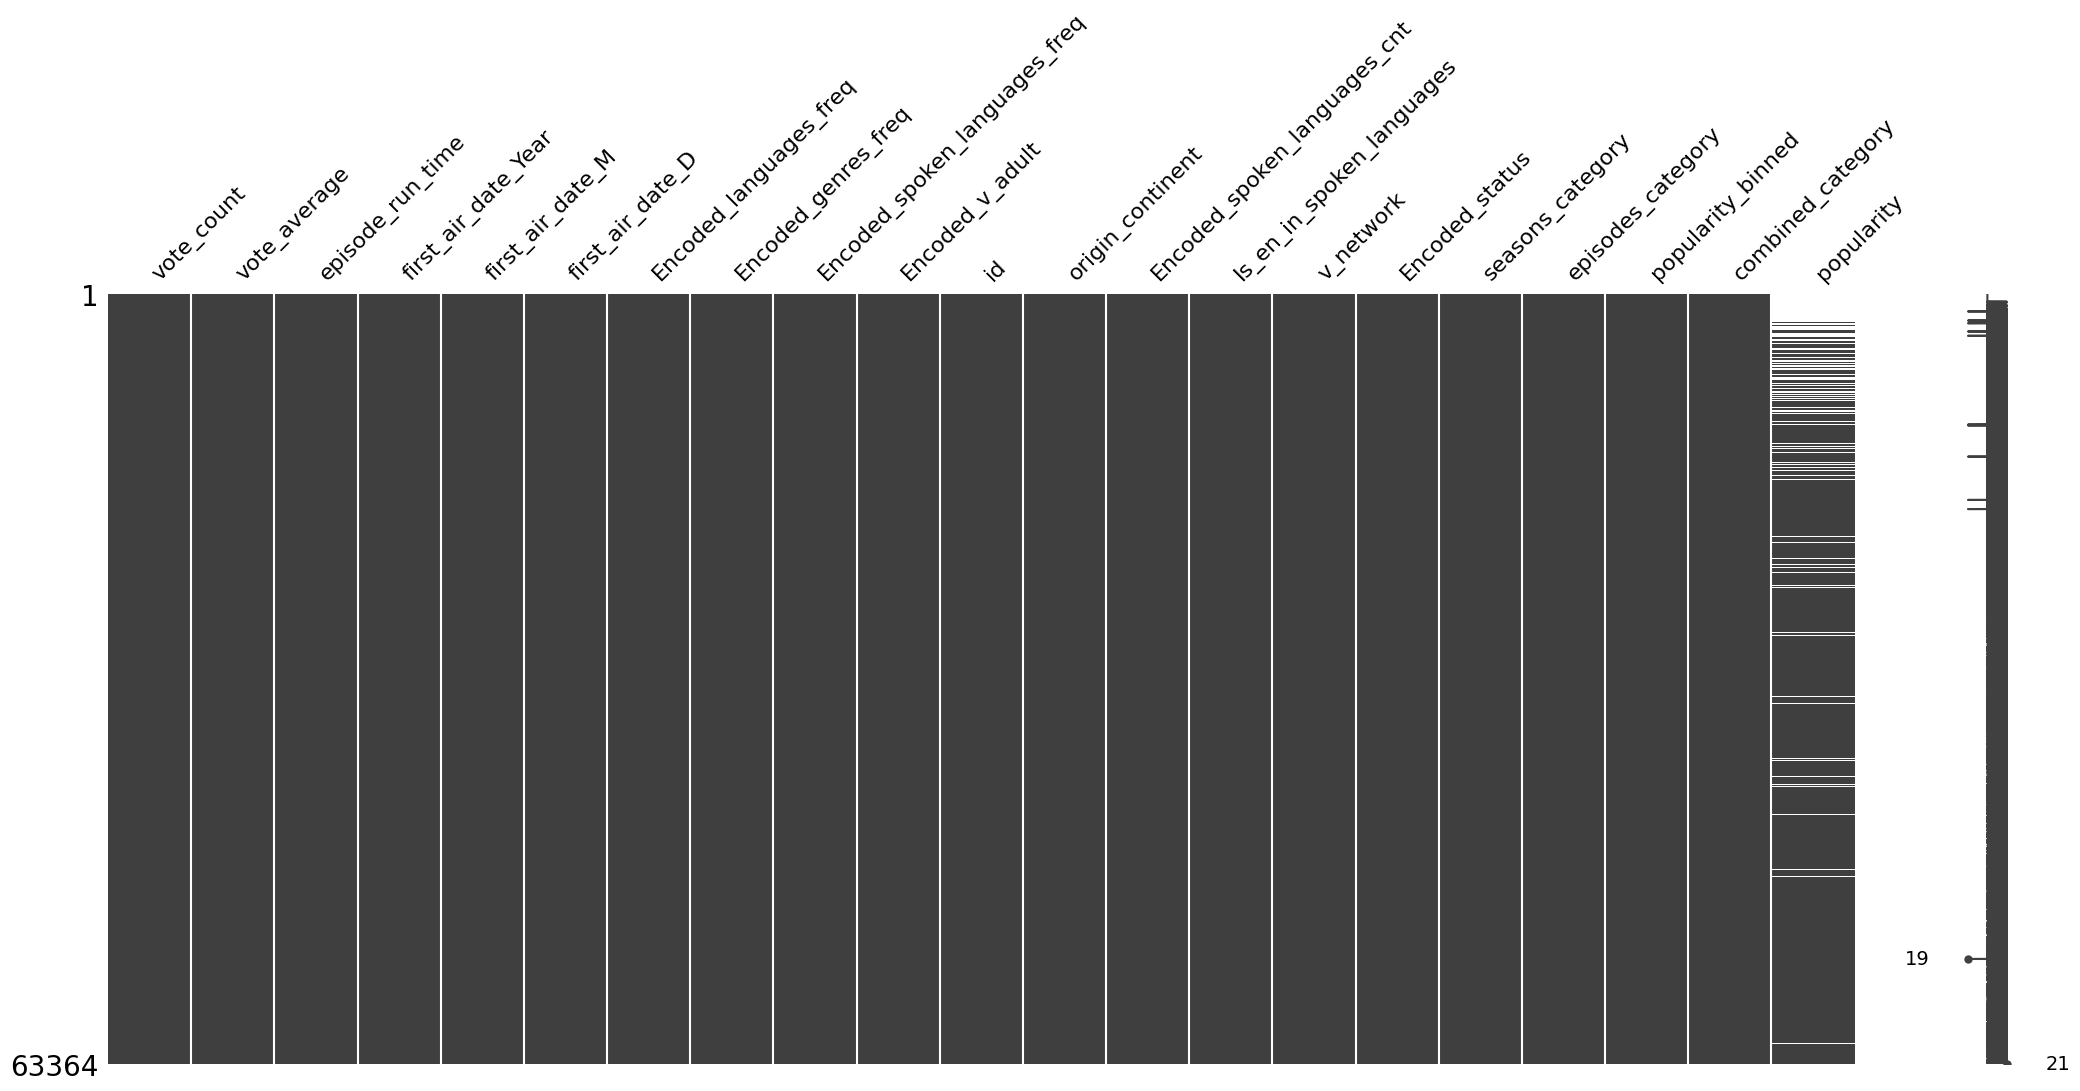

In [65]:
import missingno as msno
msno.matrix(df_imputed)

In [66]:
print(df_imputed.columns)

Index(['vote_count', 'vote_average', 'episode_run_time', 'first_air_date_Year',
       'first_air_date_M', 'first_air_date_D', 'Encoded_languages_freq',
       'Encoded_genres_freq', 'Encoded_spoken_languages_freq',
       'Encoded_v_adult', 'id', 'origin_continent',
       'Encoded_spoken_languages_cnt', 'Is_en_in_spoken_languages',
       'v_network', 'Encoded_status', 'seasons_category', 'episodes_category',
       'popularity_binned', 'combined_category', 'popularity'],
      dtype='object')


In [67]:
#3  Scaling 

In [73]:
# Scale and encode data
df_scaled = scale_and_encode(df_imputed, scale_columns=['vote_count', 'vote_average'], scaler_type='minmax')
#error
print("Imputed and Scaled DataFrame:")
print(df_scaled.head())

Shape before transformation: (63364, 21)
Shape after transformation: (63364, 21)
Imputed and Scaled DataFrame:
   vote_count  vote_average  episode_run_time  first_air_date_Year  \
0    1.000000           0.8              70.0                 2017   
1    0.906089           0.9               0.0                 2016   
2    0.777641           0.8              45.0                 2016   
3    0.738955           0.8              45.0                 2017   
4    0.731834           0.8               0.0                 2021   

   first_air_date_M  first_air_date_D  Encoded_languages_freq  \
0                 5                 2                    3853   
1                 7                15                   38671   
2                 1                25                   38671   
3                 1                26                   38671   
4                 9                17                       1   

   Encoded_genres_freq  Encoded_spoken_languages_freq  Encoded_v_adult  ...  

In [71]:
df_scaled

,vote_count,vote_average,episode_run_time,first_air_date_Year,first_air_date_M,first_air_date_D,Encoded_languages_freq,Encoded_genres_freq,Encoded_spoken_languages_freq,Encoded_v_adult,...,origin_continent,Encoded_spoken_languages_cnt,Is_en_in_spoken_languages,v_network,Encoded_status,seasons_category,episodes_category,popularity_binned,combined_category,popularity
0,1.000000,0.8,70.0,2017,5,2,3853,985,5178,0,...,Europe,1.0,False,Main Network,0,3-10,10-50,0-612,3-10 & 10-50,NaN
1,0.906089,0.9,0.0,2016,7,15,38671,110,73268,0,...,North America,1.0,True,Main Network,1,3-10,10-50,0-612,3-10 & 10-50,NaN
2,0.777641,0.8,45.0,2016,1,25,38671,14,73268,0,...,North America,1.0,True,Main Network,0,3-10,50-100,0-612,3-10 & 50-100,NaN
3,0.738955,0.8,45.0,2017,1,26,38671,409,73268,0,...,North America,1.0,True,Other,0,3-10,100-500,0-612,3-10 & 100-500,NaN
4,0.731834,0.8,0.0,2021,9,17,1,38,1,0,...,Unknown,3.0,True,Main Network,1,1-3,0-10,0-612,1-3 & 0-10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63359,0.000000,0.0,0.0,2023,11,20,1421,16282,1405,0,...,Unknown,1.0,False,Other,1,1-3,10-50,0-612,1-3 & 10-50,4.0
63360,0.000000,0.0,0.0,2023,11,30,6204,25,7377,0,...,Europe,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,3.0
63361,0.000000,0.0,0.0,2023,3,3,58589,68926,14181,0,...,Unknown,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,1.0
63362,0.000000,0.0,0.0,2023,11,30,199,1037,195,0,...,Unknown,1.0,False,Other,1,1-3,0-10,0-612,1-3 & 0-10,2.0


In [74]:
import pandas as pd

def check_scaling_statistics(df_original, df_scaled):
    # Compute descriptive statistics for both original and scaled data
    original_stats = df_original.describe()
    scaled_stats = df_scaled.describe()

    # Print the statistics
    print("Original Data Statistics:\n", original_stats)
    print("\nScaled Data Statistics:\n", scaled_stats)

# Example usage
check_scaling_statistics(dfload, df_scaled)


Original Data Statistics:
          vote_count  vote_average    popularity  episode_run_time  \
count  64211.000000  64211.000000  56142.000000      63251.000000   
mean      16.113734      2.784647      1.603594         18.249466   
std      216.268825      3.638154      1.199629         23.342397   
min        0.000000      0.000000      0.000000          0.000000   
25%        0.000000      0.000000      1.000000          0.000000   
50%        0.000000      0.000000      1.000000          0.000000   
75%        1.000000      7.000000      2.000000         40.000000   
max    17836.000000     10.000000      6.000000        105.000000   

       first_air_date_Year  first_air_date_M  first_air_date_D  \
count         64211.000000      64211.000000      64211.000000   
mean           2019.910109          6.341375         14.626513   
std               2.192514          3.503626          9.090619   
min            2016.000000          1.000000          1.000000   
25%            2018.0

In [75]:
def check_scaling_statistics(df_original, df_scaled):
    # Print columns to debug
    print("Original Data Columns:\n", df_original.columns)
    print("Scaled Data Columns:\n", df_scaled.columns)

    # Compute descriptive statistics for both original and scaled data
    original_stats = df_original.describe()
    scaled_stats = df_scaled.describe()

    # Print the statistics
    print("Original Data Statistics:\n", original_stats)
    print("\nScaled Data Statistics:\n", scaled_stats)


check_scaling_statistics(dfload,df_scaled)




Original Data Columns:
 Index(['vote_count', 'vote_average', 'popularity', 'episode_run_time',
       'first_air_date_Year', 'first_air_date_M', 'first_air_date_D',
       'origin_continent', 'Encoded_spoken_languages_cnt',
       'Is_en_in_spoken_languages', 'Encoded_languages_freq',
       'Encoded_genres_freq', 'Encoded_spoken_languages_freq', 'v_network',
       'Encoded_status', 'Encoded_v_adult', 'id', 'seasons_category',
       'episodes_category', 'popularity_binned', 'combined_category'],
      dtype='object')
Scaled Data Columns:
 Index(['vote_count', 'vote_average', 'episode_run_time', 'first_air_date_Year',
       'first_air_date_M', 'first_air_date_D', 'Encoded_languages_freq',
       'Encoded_genres_freq', 'Encoded_spoken_languages_freq',
       'Encoded_v_adult', 'id', 'origin_continent',
       'Encoded_spoken_languages_cnt', 'Is_en_in_spoken_languages',
       'v_network', 'Encoded_status', 'seasons_category', 'episodes_category',
       'popularity_binned', 'combined_

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df_original, df_scaled, features):
    for feature in features:
        if feature in df_original.columns:
            plt.figure(figsize=(12, 6))

            # Plot original data
            plt.subplot(1, 2, 1)
            sns.histplot(df_original[feature], kde=True)
            plt.title(f'{feature} - Original')

            # Plot scaled data if feature is present
            if feature in df_scaled.columns:
                plt.subplot(1, 2, 2)
                sns.histplot(df_scaled[feature], kde=True)
                plt.title(f'{feature} - Scaled')
            else:
                plt.subplot(1, 2, 2)
                plt.text(0.5, 0.5, 'Feature not scaled', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                plt.title(f'{feature} - Scaled')

            plt.tight_layout()
            plt.show()
        else:
            print(f"Feature {feature} not found in original DataFrame.")

# Example usage with feature names
plot_feature_distributions(dfload,df_scaled, ['vote_count', 'vote_average'])



KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000022C7C3ABBE0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x0000022C0D39CCA0> (for post_execute):



KeyboardInterrupt



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(df_original, df_scaled, features):
    for feature in features:
        if feature not in df_original.columns:
            print(f"Feature {feature} not found in original DataFrame.")
            continue
        if feature not in df_scaled.columns:
            print(f"Feature {feature} not found in scaled DataFrame.")
            continue

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.histplot(df_original[feature], kde=True)
        plt.title(f'{feature} - Original')

        plt.subplot(1, 2, 2)
        sns.histplot(df_scaled[feature], kde=True)
        plt.title(f'{feature} - Scaled')

        plt.tight_layout()
        plt.show()

# Example usage with feature names
plot_feature_distributions(dfload,df_scaled, ['vote_count', 'vote_average'])


In [106]:
df_final['episodes_category']

0          10-50
1          10-50
2         50-100
3        100-500
4           0-10
          ...   
63359      10-50
63360       0-10
63361       0-10
63362       0-10
63363       0-10
Name: episodes_category, Length: 63364, dtype: category
Categories (5, object): ['0-10' < '10-50' < '50-100' < '100-500' < '500-1000']

In [103]:
# Impute missing values
df_final, success_percentage = knn_impute1(df_scaled, ['popularity'])
#knn_impute_preserve_dtypes
success_percentage

Before Imputation
Shape: (63364, 21)
Missing values by column before imputation:
vote_count                          0
vote_average                        0
episode_run_time                    0
first_air_date_Year                 0
first_air_date_M                    0
first_air_date_D                    0
Encoded_languages_freq              0
Encoded_genres_freq                 0
Encoded_spoken_languages_freq       0
Encoded_v_adult                     0
id                                  0
origin_continent                    0
Encoded_spoken_languages_cnt        0
Is_en_in_spoken_languages           0
v_network                           0
Encoded_status                      0
seasons_category                    0
episodes_category                  11
popularity_binned                   1
combined_category                   0
popularity                       8069
dtype: int64

After Imputation
Shape: (63364, 21)
Missing values by column after imputation:
vote_count                  

100

<Axes: >

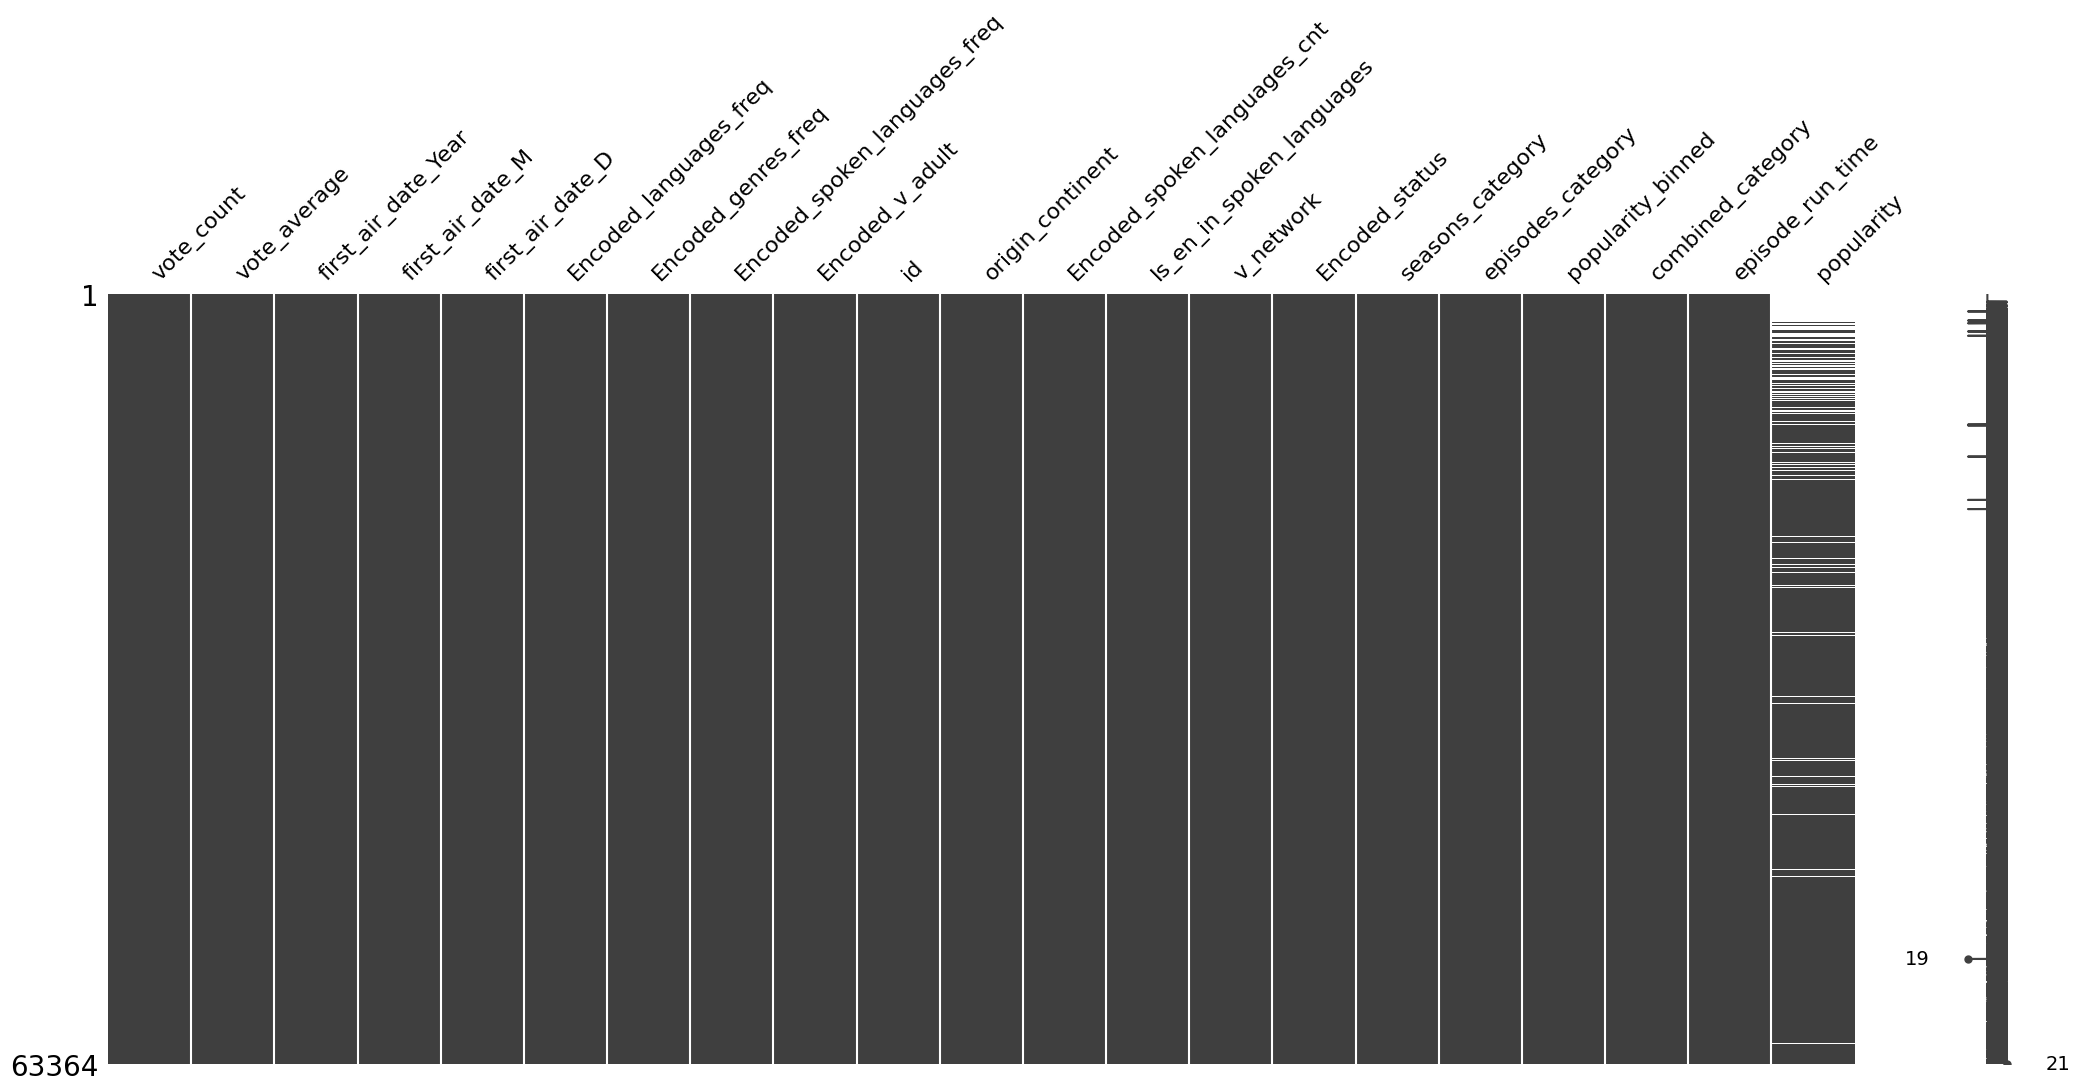

In [101]:
import missingno as msno
msno.matrix(df_final)

In [110]:
# Example usage:
df_finalto = df_final.copy()
df_final1, success = mice_impute_with_categorical(df_finalto, ['popularity', 'episodes_category'])

Before Imputation
Shape: (63364, 21)
Missing values by column before imputation:
vote_count                          0
vote_average                        0
episode_run_time                    0
first_air_date_Year                 0
first_air_date_M                    0
first_air_date_D                    0
Encoded_languages_freq              0
Encoded_genres_freq                 0
Encoded_spoken_languages_freq       0
Encoded_v_adult                     0
id                                  0
origin_continent                    0
Encoded_spoken_languages_cnt        0
Is_en_in_spoken_languages           0
v_network                           0
Encoded_status                      0
seasons_category                    0
episodes_category                  11
popularity_binned                   1
combined_category                   0
popularity                       8069
dtype: int64

After Imputation
Shape: (63364, 21)
Missing values by column after imputation:
vote_count                  

In [119]:
# Example usage:
df_final2, success = random_forest_impute(df_final1, 'popularity')




Before Imputation
Shape: (63364, 21)
Missing values by column before imputation:
vote_count                          0
vote_average                        0
episode_run_time                    0
first_air_date_Year                 0
first_air_date_M                    0
first_air_date_D                    0
Encoded_languages_freq              0
Encoded_genres_freq                 0
Encoded_spoken_languages_freq       0
Encoded_v_adult                     0
id                                  0
origin_continent                    0
Encoded_spoken_languages_cnt        0
Is_en_in_spoken_languages           0
v_network                           0
Encoded_status                      0
seasons_category                    0
popularity_binned                   0
combined_category                   0
popularity                       8069
episodes_category                  11
dtype: int64

After Imputation
Shape: (63364, 21)
Missing values by column after imputation:
vote_count                  

In [137]:


# Apply the function
imputed_data, success_rate = encode_and_catimpute(df_final2, 'episodes_category')

# Check the final data and success rate
print(imputed_data)
print(f"Success Rate: {success_rate:.2f}")



Missing values before imputation in 'episodes_category': 11
Missing values after imputation in 'episodes_category_imputed': 0
       vote_count  vote_average  episode_run_time  first_air_date_Year  \
0        1.000000           0.8              70.0                 2017   
1        0.906089           0.9               0.0                 2016   
2        0.777641           0.8              45.0                 2016   
3        0.738955           0.8              45.0                 2017   
4        0.731834           0.8               0.0                 2021   
...           ...           ...               ...                  ...   
63359    0.000000           0.0               0.0                 2023   
63360    0.000000           0.0               0.0                 2023   
63361    0.000000           0.0               0.0                 2023   
63362    0.000000           0.0               0.0                 2023   
63363    0.000000           0.0               0.0           

In [138]:
imputed_data.isna().sum()

vote_count                        0
vote_average                      0
episode_run_time                  0
first_air_date_Year               0
first_air_date_M                  0
first_air_date_D                  0
Encoded_languages_freq            0
Encoded_genres_freq               0
Encoded_spoken_languages_freq     0
Encoded_v_adult                   0
id                                0
origin_continent                  0
Encoded_spoken_languages_cnt      0
Is_en_in_spoken_languages         0
v_network                         0
Encoded_status                    0
seasons_category                  0
popularity_binned                 0
combined_category                 0
popularity                        0
episodes_category                11
episodes_category_encoded         0
episodes_category_imputed         0
dtype: int64

<Axes: >

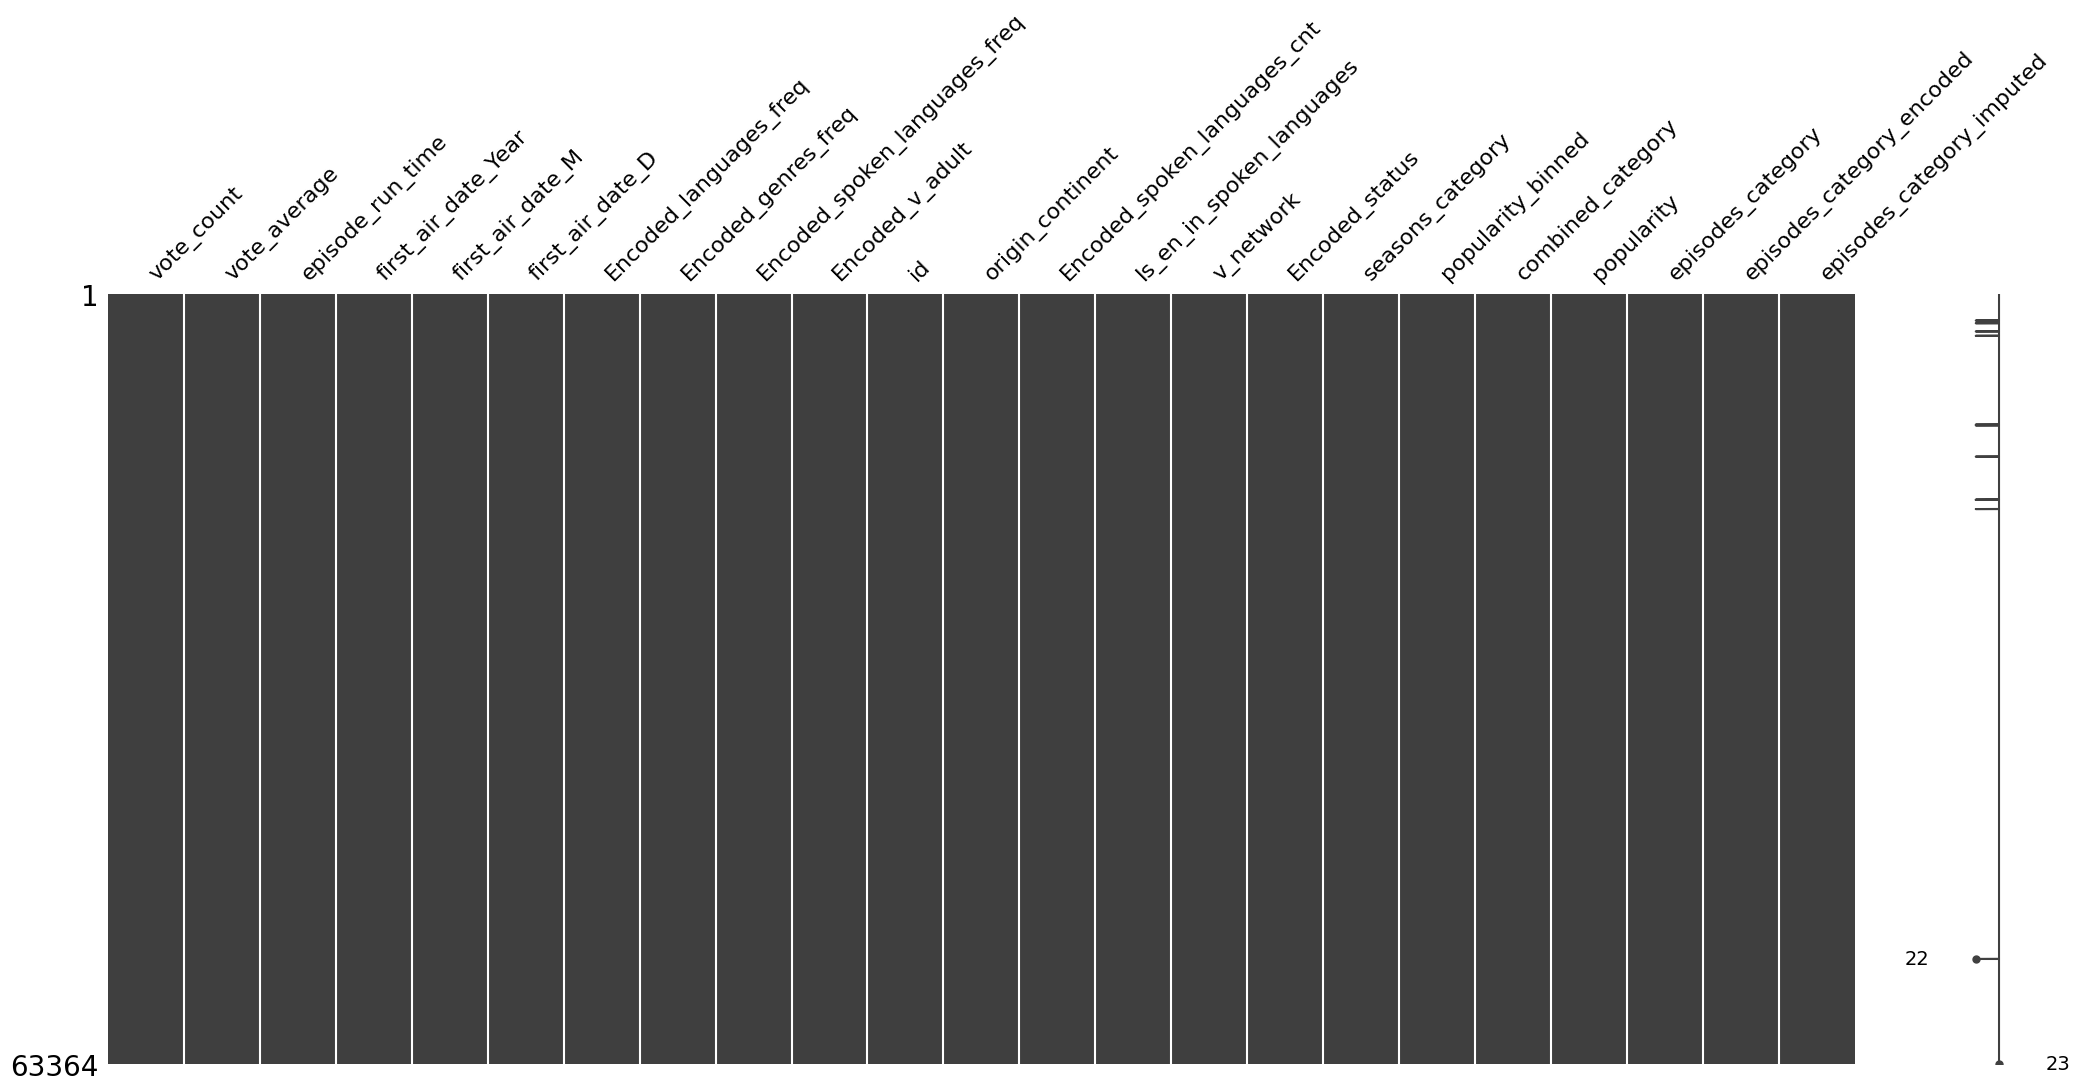

In [140]:
import missingno as msno
msno.matrix(imputed_data)